Memory-based morphology?

In [1]:
import sys
import numpy as np
import scipy
from matplotlib import pyplot as plt
from collections import *

%tensorflow_version 2.x
import tensorflow as tf
import tensorflow.keras as tkeras

import networkx as nx
import sklearn.neighbors

In [2]:
class Vocab:
  def __init__(self):
    self.alphaToInd = {}
    self.indToAlpha = {}
    self.nChars = 0
  
  def get(self, ss):
    val = self.alphaToInd.get(ss, None)
    if val is not None:
      return val

    self.alphaToInd[ss] = self.nChars
    self.indToAlpha[self.nChars] = ss
    self.nChars += 1
    return self.nChars

  def decode(self, vec):
    res = []
    for ii in range(vec.shape[0]):
      ind = np.argmax(vec[ii, :])
      if vec[ii, ind] == 0:
        res.append("0")
      else:
        res.append(self.indToAlpha[ind])
    return "".join(res)

  def decodeIndices(self, vec):
    return "".join([self.indToAlpha[ind] for ind in vec])

In [3]:
def hasFeats(fset, targets, exclude=[]):
  feats = fset.split(";")
  #print(fset, targets)
  return all([xx in feats for xx in targets]) and not any([xx in feats for xx in exclude])

def nospaces(row):
  lemma, form, feats = row
  return not " " in form

def fullParadigms(rows):
  #prefilter for missing forms
  lemmaForms = defaultdict(set)
  for lemma, form, feats in rows:
    lemmaForms[lemma].add(feats)

  fpSize = max([len(xx) for xx in lemmaForms.values()])
  print("Paradigm size guessed", fpSize)

  return [(lemma, form, feats) for (lemma, form, feats) in rows if len(lemmaForms[lemma]) == fpSize]  

def readUD(rows, target=[], exclude=[]):
  #read a UD treebank, return a list of (lemma, form, feats) tuples and a frequency count
  res = []
  counts = Counter()

  for row in rows:
    if row[0] == "#":
      continue

    num, word, lemma, pos, subtag, feats, dep, role, x1, x2 = row
    if " " in word or "-" in word:
      #exclude particles
      continue
    
    if word.endswith("'") or word.endswith("’"):
      #exclude phonological dropping of last vowel
      continue

    word = word.lower()
    lemma = lemma.lower()

    feats = "%s;%s" % (pos, feats.replace("|", ";"))
        
    if hasFeats(feats, target, exclude):
      if word not in counts:
        res.append((lemma, word, feats))

      counts[word] += 1
  
  return res, counts

In [4]:
spanish = np.loadtxt("https://raw.githubusercontent.com/unimorph/spa/master/spa", dtype=str, delimiter="\t").tolist()
irish = np.loadtxt("https://raw.githubusercontent.com/unimorph/gle/master/gle", dtype=str, delimiter="\t").tolist()
english = np.genfromtxt("https://raw.githubusercontent.com/UniversalDependencies/UD_English-GUM/master/en_gum-ud-train.conllu",
                        dtype=str, delimiter="\t", invalid_raise=False).tolist()
irishCorpus = np.genfromtxt("https://raw.githubusercontent.com/UniversalDependencies/UD_Irish-IDT/master/ga_idt-ud-train.conllu",
                            dtype=str, delimiter="\t", invalid_raise=False).tolist()

irishWords, irishFreq = readUD(irishCorpus, ["NOUN", "Case=NomAcc"], exclude=["Foreign", "Definite=Def", "Form=Len", "Form=Ecl", "Form=HPref"])
#print(len(gaelicWords))
#print(wordFreq.most_common(10))
print(irishWords[:10])

englishWords, englishFreq = readUD(english, ["NOUN"], exclude=[])

presInd = [row for row in spanish if hasFeats(row[-1], ["V", "IND", "PRS"]) and nospaces(row)]
print(presInd[:5])

nom = [row for row in irish if hasFeats(row[-1], ["N", "NOM"], exclude=["DEF"]) and nospaces(row)]
print(nom[:5])

irishWords = fullParadigms(irishWords)
nom = fullParadigms(nom)
englishWords = fullParadigms(englishWords)

replacements = {"NOUN;Number=Plur":"N;NOM;PL", "NOUN;Number=Sing":"N;NOM;SG"}
for ii in range(len(englishWords)):
  lemma, word, feats = englishWords[ii]
  englishWords[ii] = lemma, word, replacements[feats]

print(len(nom), "irish words from unimorph")
print(len(englishWords), "english words from corpus")
print(len(irishWords), "irish words from corpus")

lemmaForms = defaultdict(dict)
for (lemma, form, feats) in irishWords:
  lemmaForms[lemma][feats] = form
for li, sub in lemmaForms.items():
  print(li)
  for kk, vv in sub.items():
    print(kk, vv)
  break

workingSet = nom
charset = set()
outputSize = 0
for (lemma, form, feats) in nom + englishWords:
  for ch in form.lower():
    charset.update(ch)
  outputSize = max(outputSize, len(form) + 1)

print("Output size", outputSize)
print("Chars", charset)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: ConversionWarning: Some errors were detected !
    Line #63726 (got 2 columns instead of 10)
    Line #63779 (got 2 columns instead of 10)
    Line #63968 (got 2 columns instead of 10)
    Line #67396 (got 2 columns instead of 10)
    Line #67411 (got 2 columns instead of 10)
    Line #81674 (got 2 columns instead of 10)
    Line #81716 (got 2 columns instead of 10)
    Line #81738 (got 2 columns instead of 10)
    Line #99570 (got 2 columns instead of 10)
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: ConversionWarning: Some errors were detected !
    Line #38948 (got 2 columns instead of 10)
  


[('lár', 'lár', 'NOUN;Case=NomAcc;Gender=Masc;Number=Sing'), ('aigéan', 'áigéan', 'NOUN;Case=NomAcc;Gender=Masc;Number=Sing'), ('solas', 'solas', 'NOUN;Case=NomAcc;Gender=Masc;Number=Sing'), ('éiclips', 'éiclips', 'NOUN;Case=NomAcc;Gender=Fem;Number=Sing'), ('anam', 'anam', 'NOUN;Case=NomAcc;Gender=Masc;Number=Sing'), ('sagartóireacht', 'sagartóireacht', 'NOUN;Case=NomAcc;Gender=Fem;Number=Sing'), ('limistéar', 'limistéar', 'NOUN;Case=NomAcc;Gender=Masc;Number=Sing'), ('áit', 'áit', 'NOUN;Case=NomAcc;Gender=Fem;Number=Sing'), ('spás', 'spás', 'NOUN;Case=NomAcc;Gender=Masc;Number=Sing'), ('litir', 'litir', 'NOUN;Case=NomAcc;Gender=Fem;Number=Sing')]
[['abacorar', 'abacoráis', 'V;IND;PRS;2;PL'], ['abacorar', 'abacoramos', 'V;IND;PRS;1;PL'], ['abacorar', 'abacoran', 'V;IND;PRS;3;PL'], ['abacorar', 'abacoras', 'V;IND;PRS;2;SG'], ['abacorar', 'abacora', 'V;IND;PRS;3;SG']]
[['greadóg', 'greadóg', 'N;NOM;SG'], ['greadóg', 'greadóga', 'N;NOM;PL'], ['greamachán', 'greamachán', 'N;NOM;SG'], ['gr

In [5]:
#Grace's alignment code
cache = {}

##Returns minimum edit distance and all possible alignments for a pair of forms
def EditDistanceWithAlignment(s1, s2, level=0):
    if(len(s1)==0):
        return len(s2), set([
            (tuple(), tuple([(char, False) for char in s2]))
            ])
    if(len(s2)==0):
        return len(s1), set([
            (tuple([(char, False) for char in s1]), tuple())    
            ])
    if(s1, s2) in cache:
        return cache[(s1, s2)]
  
    if(s1[-1]==s2[-1]):
        cost = 0
    else:
        cost = 2

    op1, solutions1 = EditDistanceWithAlignment(s1[:-1], s2, level=level + 1)
    op2, solutions2 = EditDistanceWithAlignment(s1, s2[:-1], level=level + 1)
    op3, solutions3 = EditDistanceWithAlignment(s1[:-1], s2[:-1], level=level + 1)

    op1 += 1
    op2 += 1
    op3 += cost

    solutions = set()
    mincost = min(op1, op2, op3)

    if op1==mincost:
        for (sol1, sol2) in solutions1:
            solutions.add( (sol1 + ((s1[-1], False),), sol2) )
    if op2==mincost:
        for (sol1, sol2) in solutions2:
            solutions.add( (sol1, sol2 + ((s2[-1], False),)) )
    if op3==mincost and cost==0:
        for (sol1, sol2) in solutions3:
            solutions.add( (sol1 + ((s1[-1], True),), sol2 + ((s2[-1], True),)) )
    if op3==mincost and cost>0:
        for (sol1, sol2) in solutions3:
            solutions.add( (sol1 + ((s1[-1], False),), sol2 + ((s2[-1], False),)) )
    cache[(s1, s2)] = (mincost, solutions)
    
    return mincost, solutions

In [6]:
class GenData(tkeras.utils.Sequence):
  def __init__(self, words):
    self.vocab = Vocab()
    self.vocab.get("$")
    self.words = words
    self.references = None
    self.lemmaToForms = defaultdict(dict)

    for lemma, form, feats in words:
      for ch in form.lower():
        self.vocab.get(ch)
      self.lemmaToForms[lemma][feats] = form.lower()

    fLimit = 1 #fixme
    delete = []
    for lemma, sub in self.lemmaToForms.items():
      if len(sub) < fLimit:
        delete.append(lemma)

    for lemma in delete:
      del self.lemmaToForms[lemma]

    self.lemmas = list(self.lemmaToForms.keys())
    np.random.shuffle(self.lemmas)

    allForms = []
    for sub in self.lemmaToForms.values():
      allForms += list(sub.values())

    self.outputSize = int(np.percentile([len(xx) for xx in allForms], 100)) + 2
    self.inputSize = self.outputSize

    self.policy = np.random.normal(size=(7, 16))

  def setReferences(self, references):
    self.references = references
    for ri in references:
      for ci in ri:
        self.vocab.get(ci)
    
    self.nRefChars = self.inputSize * len(self.references) + 1

  def __len__(self):
    return len(self.lemmas)
  
  def getPolicy(self, targetForm):
    if targetForm.endswith("mos"):
      category = 0
    elif targetForm.endswith("s"):
      category = 3
    else:
      category = 6
    return self.policy[category, :]

  def __getitem__(self, idx):
    #print("Accessing batch", idx)
    lemma = self.lemmas[idx]
    forms = self.lemmaToForms[lemma]
    #fixme
    if np.random.random() < .5:
      lIn = self.getForm(forms, ["3", "SG"])
      lOut = self.getForm(forms, ["2", "SG"])
      policy = self.getPolicy(lOut)
    else:
      lIn = self.getForm(forms, ["3", "SG"])
      lOut = self.getForm(forms, ["1", "PL"])
      policy = self.getPolicy(lOut)
    
    #policy = np.zeros((16,))
    #lIn = forms["in"]
    #lOut = forms["out"]

    positions = np.arange(1, self.inputSize + 1, dtype="int")

    #refReprs = list(zip(
    #    self.matrixizeRefs(self.references, length=self.inputSize, pad=True),
    #    self.indexizeRefs(self.references, length=self.inputSize, tagRef=True, pad=True), 
    #))

    refReprs = self.matrixizeRefs(self.references, length=self.inputSize, pad=True)

    rval = ([self.matrixize(lIn, length=self.inputSize, pad=True),
             positions[None, ...],
             policy[None, ...],
             ] +
             refReprs,
             self.matrixize(lOut, length=self.outputSize, pad=True))
    #print("shapes", [xx.shape for xx in rval[0]], rval[1].shape)
    return rval

  def getForm(self, forms, target):
    for feats, form in forms.items():
      if hasFeats(feats, target):
        return form

  def indexize(self, ss, length=None, pad=False):
    ss = "$%s$" % ss

    if pad:
      ss += "$" * (length - len(ss))

    if length is None:
      length = len(ss)

    mat = np.zeros((1, length,))
    for ii, si in enumerate(ss[:length]):
      mat[0, ii] = self.vocab.get(si)
    return mat

  def matrixize(self, ss, length=None, pad=False):
    ss = "$%s$" % ss

    if length is None:
      length = len(ss)
    
    if pad:
      ss += "$" * (length - len(ss))

    mat = np.zeros((1, length, self.vocab.nChars))
    for ii, si in enumerate(ss[:length]):
      mat[0, ii, self.vocab.get(si)] = 1
    return mat

  def matrixizeRefs(self, refs, length, pad=False):
    return [self.matrixize(ri, length, pad=pad) for ri in refs]

  def indexizeRefs(self, refs, length, tagRef=False, pad=False):
    if not tagRef:
      return [self.indexize(ri, length) for ri in refs]
    else:
      res = []
      for rid, ri in enumerate(self.references):
        ss = "$%s$" % ri
        if pad:
          ss += "$" * (length - len(ss))

        row = np.zeros((1, length))
        for cid, ci in enumerate(ss):
          row[0, cid] = (length * rid + cid + 1)
        res.append(row)
      return res

In [7]:
class BatchAdapter(tkeras.utils.Sequence):
  def __init__(self, underlying, batchSize):
    self.underlying = underlying
    self.batchSize = batchSize
    self.indices = list(range(len(self.underlying)))
    np.random.shuffle(self.indices)

  def __len__(self):
    return len(self.underlying) // self.batchSize
  
  def __getitem__(self, idx):
    inds = self.indices[self.batchSize * idx : self.batchSize * (idx + 1)]
    batch = []
    for ii in inds:
      batch.append(self.underlying[ii])
    
    return self.restructure(batch)
  
  def restructure(self, stuff):
    if isinstance(stuff[0], np.ndarray):
      return np.concatenate(stuff)
    else:
      res = []
      for dim in range(len(stuff[0])):
        res.append(self.restructure([si[dim] for si in stuff]))
      return res

In [8]:
if False:
  instances = []
  for ii in range(1000):
    wstr = []
    alphabet = "abcdefghijklmnopqrst" + "uvwxyz"
    for jj in range(np.random.randint(5, 12)):
      wstr.append(np.random.choice(list(alphabet)))
    wstr = "".join(wstr)
    instances.append(("w%d" % ii, wstr, "in"))
    instances.append(("w%d" % ii, wstr + "xyz", "out"))
  print(instances[0], instances[1])

  data = GenData(instances)

  data.setReferences(["abcdxyz"])
elif False:
  data = GenData(presInd)
  data.setReferences(["mueves", "movemos"])
else:
  data = GenData(workingSet)

In [9]:
def parseAlt(solution, get="theme"):
  res = []
  for char, alt in solution[0]:
    if alt and get == "theme":
      res.append(char)
    elif get != "theme" and not alt:
      res.append(char)
  return "".join(res)

def segmentAll(forms):
  theme = forms[0]
  for fi in forms[1:]:
    cost, solutions = EditDistanceWithAlignment(theme, fi)
    theme = parseAlt(list(solutions)[0], "theme")
  
  #print("theme of all forms", theme)

  dists = []
  for fi in forms:
    cost, solutions = EditDistanceWithAlignment(fi, theme)
    dists.append(parseAlt(list(solutions)[0], "dist"))
    #print("distinguisher for", fi, theme, "is", dists[-1])

  return dists

microclasses = defaultdict(list)

for ii, (verb, forms) in enumerate(data.lemmaToForms.items()):
  sortedForms = [form for (cell, form) in sorted(forms.items())]
  dists = segmentAll(list(sortedForms))
  microclasses[tuple(dists)].append(verb)

print(len(microclasses), "microclasses found")
for mclass, members in sorted(microclasses.items(), key=lambda xx: len(xx[1]), reverse=True):
  print(min(members, key=len), mclass, len(members))

196 microclasses found
os ('i', '') 989
ua ('í', '') 958
muc ('a', '') 331
sách ('ig', 'c') 269
inne ('í', 'e') 252
rud ('aí', '') 214
góraí ('ithe', 'í') 171
ás ('anna', '') 148
jib ('eanna', '') 147
fear ('i', 'ea') 93
mac ('i', 'a') 87
Síneach ('ig', 'eac') 87
pá ('nna', '') 63
ál ('ta', '') 45
ail ('eacha', '') 40
líne ('t', '') 32
cúil ('acha', 'i') 31
orlach ('í', 'ch') 27
nead ('acha', '') 21
urú ('uithe', 'ú') 21
oitir ('eacha', 'i') 15
muic ('a', 'i') 15
moladh ('tí', 'dh') 12
Uasal ('ie', 'a') 12
ára ('ann', '') 12
loch ('plal', 'singla') 11
singil ('í', 'i') 10
rí ('the', '') 10
Craíoch ('g', 'oc') 10
léiriú ('the', 'ú') 8
súil ('e', '') 8
mín ('te', '') 8
duine ('ao', 'u') 8
toradh ('taí', 'ad') 8
nóin ('ta', 'i') 7
ula ('cha', '') 7
ionadh ('í', 'dh') 7
asna ('ach', '') 7
mí ('onna', '') 6
logainm ('neacha', '') 6
cill ('eaa', 'i') 6
pearsa ('na', '') 5
nae ('tha', '') 5
fiaradh ('thí', 'dh') 5
measair ('rach', 'ir') 4
sá ('ite', '') 4
nócha ('idí', '') 4
bean ('má', 'bea'

In [10]:
def extractTree(forms):
  table = defaultdict(list)
  for formTab in forms:
    flist = list(formTab.items())
    for ii, (featsI, formI) in enumerate(flist):
      for jj, (featsJ, formJ) in enumerate(flist[ii + 1:]):
        cost, solutions = EditDistanceWithAlignment(formI, formJ)
        table[(featsI, featsJ)].append(cost)

  graph = nx.Graph()
  for (featsI, featsJ), costs in table.items():
    cost = np.mean(costs)
    graph.add_edge(featsI, featsJ, weight=cost)

  spanning = nx.algorithms.tree.branchings.minimum_spanning_arborescence(graph.to_directed())

  return spanning.edges()

example = list(data.lemmaToForms.keys())[0]
extractTree([data.lemmaToForms[example]])

OutEdgeView([('N;NOM;SG', 'N;NOM;PL')])

In [11]:
class MicroclassData(GenData):
  def __init__(self, words, microclasses, charset=None, outputSize=None, balance=False, nInstances=200, batchSize=1, copy=None):
    super(MicroclassData, self).__init__(words)
    self.microclasses = microclasses
    self.copy = copy
    self.batchSize = batchSize
    self.nInstances = nInstances

    self.balance = balance

    if outputSize is not None:
      self.outputSize = outputSize
      self.inputSize = outputSize

    if charset is not None:
      for ch in charset:
        self.vocab.get(ch)

    if copy is None:
      self.sourceTab = {}
      self.referenceTab = {}
      self.policies = {}
      self.trees = {}

      mcLemmas = set()

      #this configures the model, but the string should not be used
      self.references = [ "NOTUSED" ]

      singleTree = extractTree(list(self.lemmaToForms.values())[:100])

      nxt = 0
      for (mc, members) in self.microclasses.items():
        mcLemmas.update(members)
        exemplar = list(members)[0]
        exemplarForms = self.lemmaToForms[exemplar]
        self.trees[mc] = singleTree

        for (featsI, featsJ) in self.trees[mc]:
          self.sourceTab[mc, featsJ] = featsI
          self.referenceTab[mc, featsJ] = mc, featsJ
          self.policies[mc, featsJ] = nxt
          nxt += 1
      
      self.lemmas = list(mcLemmas)

    else:
      self.referenceTab = copy.referenceTab
      self.sourceTab = copy.sourceTab
      self.policies = copy.policies
      #for (mc, cell), pol in copy.policies.items():
      #  if mc in self.microclasses:
      #    self.policies[(mc, cell)] = pol
      self.trees = copy.trees
      self.vocab = copy.vocab
      self.outputSize = copy.outputSize
      self.inputSize = copy.inputSize

    self.generateTrainingData()

    self.mode = "train"

  def policyMembers(self):
    invPol = defaultdict(list)
    for (pi, pid) in self.policies.items():
      invPol[pid].append(pi)
    return invPol

  def referenceMembers(self):
    invRef = defaultdict(list)
    for (ri, rid) in self.referenceTab.items():
      invRef[rid].append(ri)
    return invRef

  def __len__(self):
    return len(self.batchIndices) // self.batchSize

  def supports(self, mc, lemma, cell):
    forms = self.lemmaToForms[lemma]
    src = self.sourceTab.get((mc, cell))
    #print("checking support", mc, lemma, forms, src, src in forms, cell in forms)
    if src in forms and cell in forms:
      return True

  def generateTrainingData(self):
    self.batchIndices = []

    for policy, users in self.policyMembers().items():
      toGenerate = []
      for mc, cell in users:
        toGenerate += [(mc, li, cell) for li in self.microclasses.get(mc, []) if self.supports(mc, li, cell)]
      
      if self.balance is True:
        nInstances = self.nInstances
      elif type(self.balance) is dict:
        nInstances = self.balance[policy]
      else:
        nInstances = None

      if toGenerate:
        print("getting batch indices for policy", policy, len(users), "users", nInstances, "instances")  
        items = self.getBatchIndices(toGenerate, nInstances)
        self.batchIndices += items
    
    print("Generated", len(self.batchIndices), "items over", len(self.policyMembers()), "policies")

  def getBatchIndices(self, members, nInstances):
    inst = []
    if nInstances is None:
      nInstances = len(members) + 1

    while len(inst) < nInstances:
      np.random.shuffle(members)
      for mc, li, cell in members:
          inst.append((mc, li, cell))

    inst = inst[:nInstances]
    return inst

  def report(self, inflect):
    print(len(self.microclasses), "microclasses known")

    for mc, members in sorted(self.microclasses.items(), key=lambda xx: len(xx[1]), reverse=True):
      #find an example verb
      example = members[0]

      mcd = {mc : members}
      minidat = self.__class__(self.words, mcd, pUseAlignment=0, copy=self)
      minidat.batchIndices.sort(key=lambda xx: (xx[1] != example, np.random.randint(0, 500)))

      preds = inflect.predict(minidat, verbose=False, steps=min(100, len(minidat)))

      #print how many members
      overallAcc = 0
      overallDen = 0
      catAcc = defaultdict(int)
      catDen = defaultdict(int)

      for ii in range(preds.shape[0]):
        pi = self.vocab.decode(preds[ii]).strip("$0")
        dummy, li, ci = minidat.batchIndices[ii]
        ai = self.lemmaToForms[li][ci]
        overallDen += 1
        catDen[ci] += 1
        if pi == ai:
          overallAcc += 1
          catAcc[ci] += 1

      catAcc = { cat : (catAcc[cat] / den) for cat, den in catDen.items() }
      macroAvg = sum(catAcc.values()) / len(catAcc.values())
      print("#%d" % len(members), "overall acc", overallAcc / overallDen, "macroavg", macroAvg)

      #for each form, print the appropriate form, the policy in use, the reference in use, and the model prediction
      for cell, form in sorted(self.lemmaToForms[example].items()):
        print("{0: <40}".format("%s %s" % (cell, form)), end="\t")
      print()
      for cell, form in sorted(self.lemmaToForms[example].items()):
        pol = self.policies.get((mc, cell), None)
        if pol is None:
          polStr = "[-]"
        else:
         polStr = "[%d]" % pol
        ref = self.referenceTab.get((mc, cell), None)
        if ref == (mc, cell):
          refStr = "[self]"
        elif ref == None:
          refStr = "[-]"
        else:
          ex = self.microclasses[ref[0]][0]
          exA = self.lemmaToForms[ex][ref[1]]
          refStr = "[%s]" % exA
        print("{0: <40}".format("%s %s" % (polStr, refStr)), end="\t")
      print()
      for cell, form in sorted(self.lemmaToForms[example].items()):
        acc = 0
        den = 0
        specific = None
        for ii, (dummy, lx, cx) in enumerate(minidat.batchIndices[:preds.shape[0]]):
          if lx == example and cx == cell:
            specific = self.vocab.decode(preds[ii]).strip("$0")
          if cx == cell:
            answer = self.vocab.decode(preds[ii]).strip("$0")
            if answer == self.lemmaToForms[lx][cx]:
              acc += 1
            den += 1
        if den > 0:
          print("{0: <40}".format("{0} {1}/{2} = {3:.3g}".format(specific, acc, den, acc/den)), end="\t")
        else:
          print("{0: <40}".format("- -/- -"), end="\t")
      print()
      print()

  def __getitem__(self, batchIdx):
    #print("Accessing batch", idx)
    if self.batchSize == 1:
      return self.get(batchIdx)

    ins = np.zeros((self.batchSize, self.inputSize, self.vocab.nChars))
    posns = np.zeros((self.batchSize, self.inputSize))
    policies = np.zeros((self.batchSize, 1))
    #refs = [np.zeros((self.batchSize, self.inputSize, self.vocab.nChars)) for ri in self.references]
    ref = np.zeros((self.batchSize, self.inputSize, self.vocab.nChars))
    outs = np.zeros((self.batchSize, self.outputSize, self.vocab.nChars))

    for ii, idx in enumerate(range(self.batchSize * batchIdx, self.batchSize * (batchIdx + 1))):
      xs, ys = self.get(idx)
      ins[ii] = xs[0][0]
      posns[ii] = xs[1][0]
      policies[ii] = xs[2][0]
      #xrs = xs[3]
      #for rid, ri in enumerate(xrs):
      #  refs[rid][ii] = ri[0]
      ref[ii] = xs[3][0]
    
    return (ins, posns, policies, ref), outs

  def getExemplar(self, refMC, refFeats, omit=None):
    #try:
    #  references = self.microclasses[refMC]
    #except KeyError:
    #  references = self.copy.microclasses[refMC]
    
    #print("getting exemplar for", refMC, refFeats, omit)

    references = []
    try:
      ref = self.referenceMembers()[refMC, refFeats]
    except KeyError:
      ref = self.copy.referenceMembers()[refMC, refFeats]

    for mc, cell in ref:
      try:
        references += self.microclasses[mc]
      except KeyError:
        references += self.copy.microclasses[mc]

    #print("fetched mcs", ref)
    #print("list of references", references)

    if omit in references:
      references.remove(omit)

    assert(len(references) > 1) #at least 50% chance to terminate
    #exemplar = omit
    #while exemplar == omit:
    exemplar = np.random.choice(references)

    forms = self.lemmaToForms[exemplar]
    relevantForm = forms[refFeats]

    return relevantForm

  def get(self, idx):
    mc, lemma, featsJ = self.batchIndices[idx]
    forms = self.lemmaToForms[lemma]

    featsI = self.sourceTab[mc, featsJ]
    refMC, refFeats = self.referenceTab[mc, featsJ]
    lIn = forms[featsI]
    lOut = forms[featsJ]
    policy = self.policies[mc, featsJ]
    
    positions = np.arange(1, self.inputSize + 1, dtype="int")

    relevantForm = self.getExemplar(refMC, refFeats, omit=lemma)

    #print("Instance", lIn, lOut, "policy class", 
    #      self.policies[mc, featsJ], featsI, featsJ, relevantForm)

    rval = ([self.matrixize(lIn, length=self.inputSize, pad=False),
             positions[None, ...],
             policy[None, ...],
             self.matrixize(relevantForm, length=self.inputSize, pad=False)],
             self.matrixize(lOut, length=self.outputSize, pad=True),)
    #print("shapes", [xx.shape for xx in rval[0]], rval[1].shape)
    return rval

  def formIterator(self, policyOnly=False):
    for mc, lemmas in self.microclasses.items():
      for li in lemmas:
        forms = self.lemmaToForms[li]
        for cell, form in forms.items():
          if policyOnly and (mc, cell) not in self.policies:
            continue
          
          yield (mc, li, cell, form)

  def classAssignmentData(self):
    nPolicies = len(self.policyMembers())
    nReferences = len(self.referenceMembers())
    polNames = {}
    refNames = {}

    nForms = len(list(self.formIterator(policyOnly=True)))

    xs = np.zeros((nForms, self.inputSize, self.vocab.nChars))
    positions = np.zeros((nForms, self.inputSize))
    yPolicy = np.zeros((nForms, nPolicies))
    yReference = np.zeros((nForms, nReferences))

    for ind, (mc, lemma, cell, form) in enumerate(self.formIterator(policyOnly=True)):
          if (mc, cell) not in self.policies: #root of the infl. tree
            continue

          policy = self.policies[mc, cell]
          reference = self.referenceTab[mc, cell]
          if policy not in polNames:
            polNames[policy] = len(polNames)
          pN = polNames[policy]
          if reference not in refNames:
            refNames[reference] = len(refNames)
          rN = refNames[reference]
          xs[ind] = self.matrixize(form, length=self.inputSize, pad=False)
          positions[ind] = np.arange(1, self.inputSize + 1, dtype="int")
          yPolicy[ind, pN] = 1
          yReference[ind, rN] = 1

    return [xs, positions], [yPolicy, yReference], polNames, refNames

sortedMicroclasses = sorted(microclasses.items(), key=lambda xx: len(xx[1]), reverse=True)
mc0 = sortedMicroclasses[0]
#print(mc0)
classes0 = { mc0[0] : mc0[1] }
classes100 = {}
classes5 = {}
for mc, members in sortedMicroclasses:
  if len(members) > 100:
    classes100[mc] = members
  if len(members) > 5:
    classes5[mc] = members
print(len(classes5), "microclasses selected")

data = MicroclassData(workingSet, classes5, charset=charset, outputSize=outputSize, balance=True, nInstances=300, batchSize=1)
print(data.policies)


41 microclasses selected
getting batch indices for policy 0 1 users 300 instances
getting batch indices for policy 1 1 users 300 instances
getting batch indices for policy 2 1 users 300 instances
getting batch indices for policy 3 1 users 300 instances
getting batch indices for policy 4 1 users 300 instances
getting batch indices for policy 5 1 users 300 instances
getting batch indices for policy 6 1 users 300 instances
getting batch indices for policy 7 1 users 300 instances
getting batch indices for policy 8 1 users 300 instances
getting batch indices for policy 9 1 users 300 instances
getting batch indices for policy 10 1 users 300 instances
getting batch indices for policy 11 1 users 300 instances
getting batch indices for policy 12 1 users 300 instances
getting batch indices for policy 13 1 users 300 instances
getting batch indices for policy 14 1 users 300 instances
getting batch indices for policy 15 1 users 300 instances
getting batch indices for policy 16 1 users 300 instances

In [12]:
nUnits = 64
charDims = data.vocab.nChars #can go smaller, but not when the embedding matrix is the identity!

#embed a sequence
form = tkeras.layers.Input(shape=(data.inputSize, data.vocab.nChars))
pos = tkeras.layers.Input(shape=(data.inputSize,))
#mform = tkeras.layers.Masking()(form)

class PosUnit(tkeras.constraints.Constraint):
  def __init__(self):
    super(PosUnit, self).__init__()
    self.c1 = tkeras.constraints.NonNeg()
    self.c2 = tkeras.constraints.UnitNorm()

  def __call__(self, ww):
    return self.c2(self.c1(ww))
  
  def get_config(self):
    return {}

embedChar = tkeras.layers.Dense(charDims, activation=None, use_bias=False,
                                kernel_initializer='identity',
                                kernel_constraint=PosUnit(),
                                name="embedChar")
cEmbeds = embedChar(form)
embedPos = tkeras.layers.Embedding(data.inputSize + 1, charDims)
pEmbeds = embedPos(pos)

#c1 = tkeras.layers.Conv1D(nUnits, 3, padding="same", activation="relu")(cEmbeds)
#c2 = tkeras.layers.Conv1D(nUnits, 3, padding="same", activation="relu")(c1)

seq = tkeras.layers.Bidirectional(tkeras.layers.LSTM(nUnits, return_sequences=True))(cEmbeds)
seq2 = tkeras.layers.Concatenate()([pEmbeds, seq])

#seq3 = tkeras.layers.Bidirectional(tkeras.layers.LSTM(nUnits, return_sequences=True))(seq)
#seq4 = tkeras.layers.Concatenate()([pEmbeds, seq3])

mdl = tkeras.Model(inputs=[form, pos], outputs=[seq2, cEmbeds], name="inputEmbedding")

mdl.summary()

Model: "inputEmbedding"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 27, 35)]     0                                            
__________________________________________________________________________________________________
embedChar (Dense)               (None, 27, 35)       1225        input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 27)]         0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 27, 128)      51200       embedChar[0][0]                  
_____________________________________________________________________________________

In [13]:
#https://stackoverflow.com/questions/59663963/how-to-create-two-layers-with-shared-weights-where-one-is-the-transpose-of-the
class TransposedDense(tkeras.layers.Layer):
  def __init__(self, originalLayer):
    super(TransposedDense, self).__init__()
    self.originalLayer = originalLayer
    self.supports_masking = True
  
  def __call__(self, inputs):
    weights = self.originalLayer.weights[0]
    weights = tf.transpose(weights)
    val = tf.linalg.matmul(inputs, weights)
    return val

In [14]:
class ZeroOneAccuracy(tkeras.metrics.Metric):
  def __init__(self):
    super(ZeroOneAccuracy, self).__init__()
    self.correct = self.add_weight(name="correct", initializer="zeros", dtype="int32")
    self.total = self.add_weight(name="total", initializer="zeros", dtype="int32")
  
  def update_state(self, y_true, y_pred, sample_weight=None):
    assert(sample_weight is None) #not bothering to handle right now
    bsize = tf.cast(tf.reduce_sum(tf.ones_like(y_true), axis=0)[0, 0], "int32")
    self.total.assign_add(bsize)
    pred = tf.argmax(y_pred, axis=-1)
    ans = tf.argmax(y_true, axis=-1)
    corrChar = tf.cast((tf.cast(ans, "int32") == tf.cast(pred, "int32")), "int32")
    corrWord = tf.reduce_prod(corrChar, axis=-1)
    nCorrWord = tf.reduce_sum(corrWord)
    self.correct.assign_add(nCorrWord)
  
  def result(self):
    return self.correct / self.total
  
  def reset_states(self):
    self.correct.assign(0)
    self.total.assign(0)

In [15]:
zoa = ZeroOneAccuracy()
yt = np.zeros((2, 3, 4), dtype="float32")
yp = np.zeros((2, 3, 4), dtype="float32")
yt[0, 0, 1] = 1
yt[0, 1, 2] = 1
yt[0, 1, 3] = 1
yt[1, 0, 1] = 1
yt[1, 1, 3] = 1
yt[1, 2, 3] = 1

yp[0, 0, 1] = 1
yp[0, 1, 2] = 1
yp[0, 1, 3] = 1
yp[1, 0, 1] = 1
yp[1, 1, 3] = 1
yp[1, 2, 3] = 1

print(zoa(yt, yp)) #1.0

zoa.reset_states()

yp[1, 2, 3] = 0
yp[1, 2, 2] = 1

print(zoa(yt, yp)) #0.5

tf.Tensor(1.0, shape=(), dtype=float64)
tf.Tensor(0.5, shape=(), dtype=float64)


In [16]:
def smooth(prs, alpha=.05):
  unif = .5 * tf.ones_like(prs)
  return alpha * unif + (1 - alpha) * prs

class DecoderCell(tkeras.layers.Layer):
  def __init__(self, nUnits, nChars, nInput, nRef, embedChar, **kwargs):
    super(DecoderCell, self).__init__(**kwargs)
    self.nUnits = nUnits
    self.cell = tkeras.layers.LSTMCell(nUnits)
    self.embedChar = embedChar
    self.transposedChar = TransposedDense(self.embedChar)
    self.nChars = nChars
    self.nInput = nInput
    self.nRef = nRef

    self.state_size = ( (nUnits,), (self.nInput,), (self.nInput,), (self.nChars) )

    self.charEmbedSize = self.embedChar.weights[0].shape[0]
    embSize = 2 * self.nUnits + self.nChars

    self.projectInputEmb = tkeras.layers.Dense(embSize, activation="tanh")
    self.projectInputEmbB = tkeras.layers.Dense(embSize, activation="tanh")

    self.dprojA = tkeras.layers.Dense(embSize, activation="tanh")
    self.dprojB = tkeras.layers.Dense(embSize, activation="tanh")

    self.shiftA = tkeras.layers.Dense(1, activation="sigmoid")
    self.shiftB = tkeras.layers.Dense(1, activation="sigmoid")
    self.choose = tkeras.layers.Dense(1, activation="sigmoid")
    #cx = tkeras.layers.Input(shape=(self.nUnits + 2 * self.charEmbedSize,))
    #c1 = tkeras.layers.Dense(1, activation="sigmoid")(cx)
    #c2 = tkeras.layers.Dropout(.1)(c1)
    #c1 = tkeras.layers.Dense(64, activation="tanh")(cx)
    #c2 = tkeras.layers.Dense(1, activation="sigmoid")(c1)
    #self.choose = tkeras.Model(inputs=cx, outputs=c2)

  def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
    #print("getting initial stt", inputs, batch_size, dtype)
    return ([tf.zeros((batch_size, self.nUnits)), tf.zeros((batch_size, self.nUnits))], 
            tf.zeros((batch_size, self.nInput)), tf.zeros((batch_size, self.nInput * self.nRef)), tf.zeros((batch_size, self.nChars)))
  #  if batch_size is None:
  #    batch_size = tf.shape(inputs)[0]
  #  lstm = tf.zeros((batch_size, self.nUnits))
  #  return (lstm, tf.zeros(batch_size, 10), tf.zeros(batch_size, 10), tf.zeros(batch_size, self.nChars))

  def build(self, input_shape):
    #this is where we build our weights, if we have any
    #print("Behold, the build method is called!", input_shape)
    initEmbSize = 2 * self.nUnits + self.nChars
    self.cell.build((None, input_shape[1] + initEmbSize + initEmbSize + self.charEmbedSize))
    self.projectInputEmb.build((None, initEmbSize))
    self.projectInputEmbB.build((None, initEmbSize))
    self.dprojA.build((None, self.nUnits))
    self.dprojB.build((None, self.nUnits))
    self.shiftA.build((None, self.nUnits + 2 * self.charEmbedSize))
    self.shiftB.build((None, self.nUnits + 2 * self.charEmbedSize))
    self.choose.build((None, self.nUnits + 2 * self.charEmbedSize))
    self.transposedChar.build((None, self.charEmbedSize))
    self.built = True

  def call(self, inputs, states, constants=None):
    return self.__call__(inputs, states, constants=constants)

  def __call__(self, inputs, states, constants=None):
    #print("inp in call", inputs)
    #print("state in call", states)
    (lstmState, attnA, attnB, outputCh) = states
    (charsA, embedsA, charsB, embedsB) = constants

    cvA = tf.matmul(attnA, embedsA)[:, 0, :]
    cvB = tf.matmul(attnB, embedsB)[:, 0, :]

    #print("cell inp !!!", [inputs, cvA, cvB, outputCh])
    cellInputs = tf.concat([inputs, cvA, cvB, outputCh], axis=-1)
    #print("cell input tensor", cellInputs, lstmState)
    cellOutput, newLSTMState = self.cell(cellInputs, lstmState)

    #print("ran lstm cell")

    keysA = self.projectInputEmb(embedsA)
    keysB = self.projectInputEmbB(embedsB)

    #use output to compute attention
    newAttnWtsA = self.attention(cellOutput, keysA, self.dprojA)
    newAttnWtsB = self.attention(cellOutput, keysB, self.dprojB)

    maskA = tf.reduce_sum(charsA, axis=-1)
    maskB = tf.reduce_sum(charsB, axis=-1)
    newAttnWtsA *= maskA
    newAttnWtsB *= maskB

    #print("made initial attn wts")

    shiftedAttnWtsA = self.shift(attnA)[:, None, :]
    shiftedAttnWtsB = self.shift(attnB)[:, None, :]

    shiftedAttnWtsA *= maskA
    shiftedAttnWtsB *= maskB

    #print("made shifted matrices", attnA, shiftedAttnWtsA)
    #print("made shifted matrices", attnB, shiftedAttnWtsB)

    finalAttnWtsA, finalAttnA, shiftA = self.chooseAttn((newAttnWtsA, charsA), (shiftedAttnWtsA, charsA), cellOutput, self.shiftA)
    finalAttnWtsB, finalAttnB, shiftB = self.chooseAttn((newAttnWtsB, charsB), (shiftedAttnWtsB, charsB), cellOutput, self.shiftB)

    #unifAttnA = maskA / tf.reduce_sum(maskA, axis=-1, keepdims=True)
    #finalAttnWtsA = .05 * unifAttnA + .95 * finalAttnWtsA

    #unifAttnB = maskB / tf.reduce_sum(maskB, axis=-1, keepdims=True)
    #finalAttnWtsB = .05 * unifAttnB + .95 * finalAttnWtsB

    #print("survived till here")

    dummy, chosen, choose = self.chooseAttn((finalAttnWtsA, charsA), (finalAttnWtsB, charsB), cellOutput, self.choose, computeWeights=False)
    chosen = chosen[:, 0, :]
    
    embedChosen = self.transposedChar(chosen)
    result = tkeras.layers.Activation("softmax")(embedChosen)

    nextState = (newLSTMState, finalAttnWtsA[:, 0, :], finalAttnWtsB[:, 0, :], result)
    output = ([finalAttnWtsA[:, 0, :], finalAttnWtsB[:, 0, :], newAttnWtsA, newAttnWtsB, shiftedAttnWtsA, shiftedAttnWtsB],
              [shiftA, shiftB, choose],
              result)
    
    return output, nextState
  
  def attention(self, queries, keys, project=None):
    #print("attn: projecting", queries)
    if project is not None:
      queries = project(queries)

    #print("attn: query size", queries, "key size", keys)
    
    wts = tf.matmul(queries[:, None, :], keys, transpose_b=True)
    wts = tf.nn.softmax(wts)

    #print("computed weights, size", wts)
    return wts
  
  def shift(self, attnMatrix):
    return tf.pad(attnMatrix, [[0, 0], [1, 0]])[:, :-1]
  
  def chooseAttn(self, srA, srB, state, project, computeWeights=True):
    (wtsA, valsA) = srA
    (wtsB, valsB) = srB
    #print("choosing attn", wtsA, valsA, "::", wtsB, valsB)
    cvA = tf.matmul(wtsA, valsA)[:, 0, :]
    cvB = tf.matmul(wtsB, valsB)[:, 0, :]
    #print("pr input", state, cvA, cvB)
    prInput = tf.concat([state, cvA, cvB], axis=-1)
    prOutput = project(prInput)[:, :, None]

    #clip choice tensor to allow gradients to propagate--- should be harmless?
    prOutput = smooth(prOutput, alpha=.05)

    #print("linear combination", prOutput, wtsA, wtsB)

    if computeWeights:
      wtsOut = prOutput * wtsA + (1 - prOutput) * wtsB
    else:
      wtsOut = tf.zeros_like(wtsA)
    valsOut = prOutput * cvA[:, None, :] + (1 - prOutput) * cvB[:, None, :]

    #print("chose", wtsOut, valsOut)

    return wtsOut, valsOut, prOutput


In [17]:
inpForm = tkeras.layers.Input(shape=(data.inputSize, data.vocab.nChars))
inpPos = tkeras.layers.Input(shape=(data.inputSize,))
#inpRefs = [tkeras.layers.Input(shape=(data.inputSize, data.vocab.nChars)) for ri in data.references]
#inpRefs = [[tkeras.layers.Input(shape=(data.inputSize, data.vocab.nChars)), tkeras.layers.Input(shape=(data.inputSize,))] for ri in data.references]
inpRef = tkeras.layers.Input(shape=(data.inputSize, data.vocab.nChars))
inpPol = tkeras.layers.Input(shape=(1,))

embeddedIn, inChars = mdl([inpForm, inpPos])

embeddedRef, refChars = mdl([inpRef, inpPos])
#rfs = [mdl([ri, inpPos]) for ri in inpRefs]
#embeddedRefs = [rf[0] for rf in rfs]
#refChars = [rf[1] for rf in rfs]

#flatRef = tkeras.layers.Lambda(lambda xx: tf.concat(xx, axis=1))(refChars)
#flatEmbeds = tkeras.layers.Lambda(lambda xx: tf.concat(xx, axis=1))(embeddedRefs)

embedPolicy = tkeras.layers.Embedding(1000, 16)
polEmb = embedPolicy(inpPol)[:, 0, :]

policy = tkeras.layers.RepeatVector(data.outputSize)(polEmb)

xdec = DecoderCell(nUnits, data.vocab.nChars, data.inputSize, len(data.references), embedChar)
decoder = tkeras.layers.RNN(xdec, return_sequences=True)
(attns, shifts, result) = decoder(policy, constants=[inChars, embeddedIn, refChars, embeddedRef])

print("description of sequence output", (attns, shifts, result))

inflect = tkeras.Model(inputs=[inpForm, inpPos, inpPol, inpRef], outputs=result)

#prevents characters from being embedded non-faithfully
embedChar.trainable = False
xdec.transposedChar.trainable = False

#0.00000001,
schedule = tkeras.optimizers.schedules.PolynomialDecay(initial_learning_rate=.001,
                                                       end_learning_rate=.00001,
                                                       decay_steps=100*1000,
                                                       power=2)

inflect.compile(loss="categorical_crossentropy",
                metrics=["categorical_accuracy", ZeroOneAccuracy()],
                optimizer=tkeras.optimizers.Adam())###learning_rate=schedule))

inflect.summary()

description of sequence output ([<tf.Tensor 'rnn/transpose_2:0' shape=(None, 27, 27) dtype=float32>, <tf.Tensor 'rnn/transpose_3:0' shape=(None, 27, 27) dtype=float32>, <tf.Tensor 'rnn/transpose_4:0' shape=(None, 27, None, 27) dtype=float32>, <tf.Tensor 'rnn/transpose_5:0' shape=(None, 27, None, 27) dtype=float32>, <tf.Tensor 'rnn/transpose_6:0' shape=(None, 27, None, 27) dtype=float32>, <tf.Tensor 'rnn/transpose_7:0' shape=(None, 27, None, 27) dtype=float32>], [<tf.Tensor 'rnn/transpose_8:0' shape=(None, 27, 1, 1) dtype=float32>, <tf.Tensor 'rnn/transpose_9:0' shape=(None, 27, 1, 1) dtype=float32>, <tf.Tensor 'rnn/transpose_10:0' shape=(None, 27, 1, 1) dtype=float32>], <tf.Tensor 'rnn/transpose_11:0' shape=(None, 27, 35) dtype=float32>)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            

In [18]:
class PretrainData(MicroclassData):
  def __init__(self, *args, **kwargs):
    self.pUseAlignment = kwargs.pop("pUseAlignment")
    super(PretrainData, self).__init__(*args, **kwargs)
  
  def get(self, idx):
    mc, lemma, featsJ = self.batchIndices[idx]
    forms = self.lemmaToForms[lemma]

    featsI = self.sourceTab[mc, featsJ]
    refMC, refFeats = self.referenceTab[mc, featsJ]
    lIn = forms[featsI]
    lOut = forms[featsJ]
    policy = np.array([self.policies[mc, featsJ]])
    
    positions = np.arange(1, self.inputSize + 1, dtype="int")

    relevantForm = self.getExemplar(refMC, refFeats, omit=lemma)

    if np.random.random() < .5:
      cost, alts = EditDistanceWithAlignment(lIn, lOut)
      altI = np.random.randint(len(alts))
      alt = list(alts)[altI]
      altIn, altOut = alt

      bits = np.ones((self.outputSize), dtype="float32")
      for ii, xi in enumerate(altOut):
        bits[ii + 1] = xi[1]
    else:
      cost, alts = EditDistanceWithAlignment(relevantForm, lOut)
      altI = np.random.randint(len(alts))
      alt = list(alts)[altI]
      altIn, altOut = alt

      bits = np.ones((self.outputSize), dtype="float32")
      for ii, xi in enumerate(altOut):
        bits[ii + 1] = 1 - xi[1]
    #print("aligned", lIn, lOut, bits)

    switch = np.array([np.random.random() < self.pUseAlignment], dtype="float32")

    #print("Instance", lIn, lOut, "policy class", 
    #      self.policies[mc, featsJ], featsI, featsJ, relevantForm)

    rval = ([self.matrixize(lIn, length=self.inputSize, pad=False),
             positions[None, ...],
             policy[None, ...],
             self.matrixize(relevantForm, length=self.inputSize, pad=False),
             bits[None, ...],
             switch[None, ...]],
             self.matrixize(lOut, length=self.outputSize, pad=True))
    #print("shapes", [xx.shape for xx in rval[0]], rval[1].shape)
    return rval

class PretrainDecoderCell(DecoderCell):
  def __init__(self, *args):
    super(PretrainDecoderCell, self).__init__(*args)

  def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
    #print("getting initial stt", inputs, batch_size, dtype)
    return ([tf.zeros((batch_size, self.nUnits)), tf.zeros((batch_size, self.nUnits))], 
            tf.zeros((batch_size, self.nInput)), tf.zeros((batch_size, self.nInput * self.nRef)), tf.zeros((batch_size, self.nChars),))

  def build(self, input_shape):
    #this is where we build our weights, if we have any
    #print("Behold, the build method is called!", input_shape)
    initEmbSize = 2 * self.nUnits + self.nChars
    self.cell.build((None, 16 + initEmbSize + initEmbSize + self.charEmbedSize))
    self.projectInputEmb.build((None, initEmbSize))
    self.projectInputEmbB.build((None, initEmbSize))
    self.dprojA.build((None, self.nUnits))
    self.dprojB.build((None, self.nUnits))
    self.shiftA.build((None, self.nUnits + 2 * self.charEmbedSize))
    self.shiftB.build((None, self.nUnits + 2 * self.charEmbedSize))
    self.choose.build((None, self.nUnits + 2 * self.charEmbedSize))
    self.transposedChar.build((None, self.charEmbedSize))
    self.built = True

  def __call__(self, inputs, states, constants=None):
    #print("inp in call", inputs)
    #print("state in call", states)
    (lstmState, attnA, attnB, outputCh) = states
    (charsA, embedsA, charsB, embedsB, policy, useAlignment) = constants

    cvA = tf.matmul(attnA, embedsA)[:, 0, :]
    cvB = tf.matmul(attnB, embedsB)[:, 0, :]

    policy = policy[:, 0, :]

    #print("cell inp !!!", [policy, cvA, cvB, outputCh])
    cellInputs = tf.concat([policy, cvA, cvB, outputCh], axis=-1)
    #print("cell input tensor", cellInputs, lstmState)
    cellOutput, newLSTMState = self.cell(cellInputs, lstmState)

    #print("ran lstm cell")

    keysA = self.projectInputEmb(embedsA)
    keysB = self.projectInputEmbB(embedsB)

    #use output to compute attention
    newAttnWtsA = self.attention(cellOutput, keysA, self.dprojA)
    newAttnWtsB = self.attention(cellOutput, keysB, self.dprojB)

    maskA = tf.reduce_sum(charsA, axis=-1)
    maskB = tf.reduce_sum(charsB, axis=-1)
    newAttnWtsA *= maskA
    newAttnWtsB *= maskB

    #print("made initial attn wts")

    shiftedAttnWtsA = self.shift(attnA)[:, None, :]
    shiftedAttnWtsB = self.shift(attnB)[:, None, :]

    shiftedAttnWtsA *= maskA
    shiftedAttnWtsB *= maskB

    #print("made shifted matrices", attnA, shiftedAttnWtsA)
    #print("made shifted matrices", attnB, shiftedAttnWtsB)

    finalAttnWtsA, finalAttnA, shiftA = self.chooseAttn((newAttnWtsA, charsA), (shiftedAttnWtsA, charsA), cellOutput, self.shiftA)
    finalAttnWtsB, finalAttnB, shiftB = self.chooseAttn((newAttnWtsB, charsB), (shiftedAttnWtsB, charsB), cellOutput, self.shiftB)

    #unifAttnA = maskA / tf.reduce_sum(maskA, axis=-1, keepdims=True)
    #finalAttnWtsA = .05 * unifAttnA + .95 * finalAttnWtsA

    #unifAttnB = maskB / tf.reduce_sum(maskB, axis=-1, keepdims=True)
    #finalAttnWtsB = .05 * unifAttnB + .95 * finalAttnWtsB

    #print("survived till here")

    dummy, chosen, choose = self.chooseAttn((finalAttnWtsA, charsA), (finalAttnWtsB, charsB), cellOutput, self.choose, computeWeights=False)
    alignment = inputs[..., None]
    choose = alignment * useAlignment + choose * (1 - useAlignment)
    chosen = choose * finalAttnA + (1 - choose) * finalAttnB
    chosen = chosen[:, 0, :]

    #print("chose", chosen, "choose", choose)

    embedChosen = self.transposedChar(chosen)
    result = tkeras.layers.Activation("softmax")(embedChosen)

    nextState = (newLSTMState, finalAttnWtsA[:, 0, :], finalAttnWtsB[:, 0, :], result)
    output = ([finalAttnWtsA[:, 0, :], finalAttnWtsB[:, 0, :], newAttnWtsA, newAttnWtsB, shiftedAttnWtsA, shiftedAttnWtsB],
              [shiftA, shiftB, choose],
              result)
    
    return output, nextState

inpForm = tkeras.layers.Input(shape=(data.inputSize, data.vocab.nChars))
inpPos = tkeras.layers.Input(shape=(data.inputSize,))
#inpRefs = [tkeras.layers.Input(shape=(data.inputSize, data.vocab.nChars)) for ri in data.references]
#inpRefs = [[tkeras.layers.Input(shape=(data.inputSize, data.vocab.nChars)), tkeras.layers.Input(shape=(data.inputSize,))] for ri in data.references]
inpRef = tkeras.layers.Input(shape=(data.inputSize, data.vocab.nChars))
inpPol = tkeras.layers.Input(shape=(1,))
inpAlignment = tkeras.layers.Input(shape=(data.outputSize, 1), name="inpalignment")
inpUseAlignment = tkeras.layers.Input(shape=(1,), name="inpusealignment")

embeddedIn, inChars = mdl([inpForm, inpPos])

embeddedRef, refChars = mdl([inpRef, inpPos])
#rfs = [mdl([ri, inpPos]) for ri in inpRefs]
#embeddedRefs = [rf[0] for rf in rfs]
#refChars = [rf[1] for rf in rfs]

#flatRef = tkeras.layers.Lambda(lambda xx: tf.concat(xx, axis=1))(refChars)
#flatEmbeds = tkeras.layers.Lambda(lambda xx: tf.concat(xx, axis=1))(embeddedRefs)

embedPolicy = tkeras.layers.Embedding(1000, 16)
polEmb = embedPolicy(inpPol)

#policy = tkeras.layers.RepeatVector(data.outputSize)(polEmb)

xdec = PretrainDecoderCell(nUnits, data.vocab.nChars, data.inputSize, len(data.references), embedChar)
decoder = tkeras.layers.RNN(xdec, return_sequences=True)
(attns, shifts, result) = decoder(inpAlignment, constants=[inChars, embeddedIn, refChars, embeddedRef, polEmb, inpUseAlignment])

print("description of sequence output", (attns, shifts, result))

inflect = tkeras.Model(inputs=[inpForm, inpPos, inpPol, inpRef, inpAlignment, inpUseAlignment], outputs=result)

embedChar.trainable = False
xdec.transposedChar.trainable = False

schedule = tkeras.optimizers.schedules.PolynomialDecay(initial_learning_rate=.001,
                                                       end_learning_rate=.00001,
                                                       decay_steps=100*1000,
                                                       power=2)

inflect.compile(loss="categorical_crossentropy",
                metrics=["categorical_accuracy", ZeroOneAccuracy()],
                optimizer=tkeras.optimizers.Adam())

inflect.summary()

description of sequence output ([<tf.Tensor 'rnn_1/transpose_2:0' shape=(None, 27, 27) dtype=float32>, <tf.Tensor 'rnn_1/transpose_3:0' shape=(None, 27, 27) dtype=float32>, <tf.Tensor 'rnn_1/transpose_4:0' shape=(None, 27, None, 27) dtype=float32>, <tf.Tensor 'rnn_1/transpose_5:0' shape=(None, 27, None, 27) dtype=float32>, <tf.Tensor 'rnn_1/transpose_6:0' shape=(None, 27, None, 27) dtype=float32>, <tf.Tensor 'rnn_1/transpose_7:0' shape=(None, 27, None, 27) dtype=float32>], [<tf.Tensor 'rnn_1/transpose_8:0' shape=(None, 27, 1, 1) dtype=float32>, <tf.Tensor 'rnn_1/transpose_9:0' shape=(None, 27, 1, 1) dtype=float32>, <tf.Tensor 'rnn_1/transpose_10:0' shape=(None, 27, None, 1) dtype=float32>], <tf.Tensor 'rnn_1/transpose_11:0' shape=(None, 27, 35) dtype=float32>)
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (

In [19]:
import h5py
import pickle

def checkpoint(inflect, data, run, trains, merges):
  idName = "%s-%dtr-%dmr" % (run, trains, merges)
  print("Writing checkpoint", idName)
  fileName = "drive/My Drive/model/inflect-%s.h5" % idName
  fh = h5py.File(fileName,'w')
  weight = inflect.get_weights()
  for i in range(len(weight)):
    fh.create_dataset('weight'+str(i),data=weight[i])
  fh.close()

  dataName = "drive/My Drive/model/data-%s.dump" % idName
  with open(dataName, 'wb') as fh:
    pickle.dump(data, fh)

def restore(inflect, run, trains, merges):
  idName = "%s-%dtr-%dmr" % (run, trains, merges)
  fileName = "drive/My Drive/model/inflect-%s.h5" % idName
  fh = h5py.File(fileName,'r')
  weight = inflect.weights

  for ii in range(len(weight)):
    wt = weight[ii]
    wt.assign(fh["weight" + str(ii)])
  fh.close()

  dataName = "drive/My Drive/model/data-%s.dump" % idName
  with open(dataName, 'rb') as fh:
    data = pickle.load(fh)
  
  return data

data = PretrainData(workingSet, classes5, charset=charset, outputSize=outputSize, balance=True, nInstances=1000, batchSize=1, pUseAlignment=1)
checkpoint(inflect, data, "foo", 0, 0)
data = restore(inflect, "foo", 0, 0)
inflect.evaluate(data, steps=100)

getting batch indices for policy 0 1 users 1000 instances
getting batch indices for policy 1 1 users 1000 instances
getting batch indices for policy 2 1 users 1000 instances
getting batch indices for policy 3 1 users 1000 instances
getting batch indices for policy 4 1 users 1000 instances
getting batch indices for policy 5 1 users 1000 instances
getting batch indices for policy 6 1 users 1000 instances
getting batch indices for policy 7 1 users 1000 instances
getting batch indices for policy 8 1 users 1000 instances
getting batch indices for policy 9 1 users 1000 instances
getting batch indices for policy 10 1 users 1000 instances
getting batch indices for policy 11 1 users 1000 instances
getting batch indices for policy 12 1 users 1000 instances
getting batch indices for policy 13 1 users 1000 instances
getting batch indices for policy 14 1 users 1000 instances
getting batch indices for policy 15 1 users 1000 instances
getting batch indices for policy 16 1 users 1000 instances
getting

[3.5128817558288574, 0.32777777314186096, 0.0]

In [20]:
def trainModel(data, inflect, run, iters=3, nTrain=0, nMerge=0, epochs=10, verbose=1):
  data.generateTrainingData()
  pUseAlignment = data.pUseAlignment
  data.pUseAlignment = 0
  inflect.evaluate(data, steps=1000, verbose=verbose)
  data.pUseAlignment = pUseAlignment
    
  for ii in range(iters):
    inflect.fit(data, epochs=epochs, steps_per_epoch=1000, verbose=verbose)
    pUseAlignment = max(data.pUseAlignment - .05, .75)
    data.pUseAlignment = 0
    inflect.evaluate(data, steps=1000, verbose=verbose)
    data.pUseAlignment = pUseAlignment
    print("Step", ii, "alignment prob", data.pUseAlignment)
    data.generateTrainingData()
    checkpoint(inflect, data, run, nTrain + ii, nMerge)

In [21]:
def policyMatrix(data):
  policies = data.policyMembers()
  plm = np.zeros((len(policies), polEmb.shape[-1]))
  labels = []
  pids = []
  for ii, (pid, pis) in enumerate(policies.items()):
    labels.append(pis)
    pids.append(pid)
    plm[ii] = embedPolicy(np.array([pid]))

  return plm, labels, pids

def referenceMatrix(data):
  refs = data.referenceMembers()
  plm = np.zeros((len(refs), data.inputSize))
  labels = []
  pids = []
  for ii, (rid, users) in enumerate(refs.items()):
    labels.append(rid)
    pids.append(rid)
    mc, cell = rid
    exemplar = list(data.microclasses[mc])[0]
    form = data.lemmaToForms[exemplar][cell]
    positions = np.arange(1, data.inputSize + 1, dtype="int")
    embed, cemb = mdl([data.matrixize(form, length=data.inputSize, pad=False),
                positions[None, ...]])
    plm[ii] = np.mean(embed[0], axis=1)

  return plm, labels, pids

def closestPolicies(data):
  plm, labels, pids = policyMatrix(data)
  nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=plm.shape[0]).fit(plm)
  distances, indices = nbrs.kneighbors(plm)
  return indices[:, 1:], labels, pids

def closestReferences(data):
  rlm, labels, rids = referenceMatrix(data)
  nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=rlm.shape[0]).fit(rlm)
  distances, indices = nbrs.kneighbors(rlm)

  for ii in range(indices.shape[0]):
    row = indices[ii, :].tolist()
    rowCell = rids[ii][1]
    rowWithCell = [(rids[num][1], num) for num in row]
    
    #print(rowCell)
    #print(rowWithCell)

    rowWithCell.sort(key=lambda xx: xx[0] != rowCell)
    
    #print(rowWithCell)
    #assert(0)
    
    indices[ii] = [num for (cellVal, num) in rowWithCell]

  return indices[:, 1:], labels, rids

def policyName(policyMembers, short=False):
  if short:
    return policyMembers[0][1]
  return "/".join([lab[1] for lab in policyMembers])

def referenceName(members, short=False):
  return members[1]

nbrs, labels, pids = closestPolicies(data)
for (li, nbrsi, pidi) in zip(labels, nbrs, pids):
  print(pidi, policyName(li), ":", nbrsi)

print()
print("-------------")
print()

nbrs, labels, pids = closestReferences(data)
for (li, nbrsi, pidi) in zip(labels, nbrs, pids):
  print(pidi, referenceName(li), ":", [(nbri, pids[nbri]) for nbri in nbrsi])

0 N;NOM;PL : [ 3 22  2 12 17 32 35 26 31 28 37 16  6 14 34 11 33  7  8 30 20 18 27  1
 36 29 10  9  4 13 21 39 19 23  5 38 25 15 40 24]
1 N;NOM;PL : [16 30 23 18  3  4  9 19 32 10 25  7 13  0 29 21 33 37  2  6  5 24 26 11
 20 35 12 38 22 28 34 14 39 17 31 15 40 36 27  8]
2 N;NOM;PL : [ 6  0 37 14 39 26 30 20 13  8 34 33 29 17 10 16 40  3  1 23 28 12  9  4
  7 38 11 19 36  5 25 15 32 22 27 18 31 35 21 24]
3 N;NOM;PL : [12  0 16 19  1 21 23  7 18 33 32 22  9 31 17 26 37  6 30 25 39 15 11 35
  2 27 14 20 29  8 34  4 28 10  5 13 36 40 24 38]
4 N;NOM;PL : [30 16 18  1 26 10 21 24 25  5 13 37 38 11 12  9 36 23  6 15 22 29  3 32
 35 27 34  2 33 40  0 31 14 39  7 17 20 28  8 19]
5 N;NOM;PL : [18 16 29 36 40 26 23 22  7 32  9 10 37 14 35  4 24 38 20  8 39 17 30 27
  1 25 31 11 21 34  3  6 13 19 12  0  2 15 28 33]
6 N;NOM;PL : [ 2 26 15 16 33  8  0 37  3 14 18 12 10 17 29  4  1 20 34 30 23 11 32 31
  5 39 19 22  9 13 25  7 35 36 28 27 40 21 24 38]
7 N;NOM;PL : [16  3  5 14 23  8  0  9 38  1 17 2

In [22]:
def policyMove(inflect, data, mcCell, label, group="policy", nSamples=200):
  dummyClasses = {}
  pm2 = PretrainData(data.words, dummyClasses, pUseAlignment=0, balance=True, copy=data, nInstances=nSamples)
  if group == "policy":
    currentLabelUsers = [(mc, cell) for (mc, cell) in data.policyMembers()[label]]
    if not currentLabelUsers:
      return False
    pm2.policies = dict(pm2.policies.items())
    pm2.microclasses = { mci : mciMembers for mci, mciMembers in data.microclasses.items() if mci in currentLabelUsers or mci == mcCell[0] }
    pm2.generateTrainingData()
    pm2.policies[mcCell] = label
  else:
    currentLabelUsers = [(mc, cell) for (mc, cell) in data.referenceMembers()[label]]
    currentLabelMCs = [mc for (mc, cell) in currentLabelUsers]
    if not currentLabelUsers:
      return False
    pm2.policies = dict(pm2.policies.items())
    pm2.referenceTab = dict(pm2.referenceTab.items())
    pm2.microclasses = { mci : mciMembers for mci, mciMembers in data.microclasses.items() if mci in currentLabelMCs or mci == mcCell[0] }
    for li in currentLabelUsers:
      pm2.policies[li] = 1
    pm2.policies[mcCell] = 2
    pm2.generateTrainingData()
    for li in currentLabelUsers:
      pm2.policies[li] = data.policies[li]
    pm2.policies[mcCell] = data.policies[mcCell]
    pm2.referenceTab[mcCell] = label

  llMoved, accMoved, zeroOneMoved = inflect.evaluate(pm2, verbose=0)

  print(len(pm2), "instances with z1s", zeroOneMoved)
  #print("merged class is", pm2.mergedClass)

  if zeroOneMoved > .9:
    print("Executing", mcCell, "to", label, zeroOneMoved)
    if group == "policy":
      data.policies[mcCell] = label
    else:
      data.referenceTab[mcCell] = label
    return True
  else:
    print("No merge", mcCell, "to", label, zeroOneMoved)

    return False

def policyMerge(inflect, data, label1, label2, group="policy", nSamples=200):
  dummyClasses = {}
  pm2 = PretrainData(data.words, dummyClasses, pUseAlignment=0, balance=True, copy=data, nInstances=nSamples)
  if group == "policy":
    lu1 = [(mc, cell) for (mc, cell) in data.policyMembers()[label1]]
    lu2 = [(mc, cell) for (mc, cell) in data.policyMembers()[label2]]
    if not lu1 or not lu2:
      return False
    micros = [mc for (mc, cell) in lu1 + lu2]
    pm2.policies = dict(pm2.policies.items())
    pm2.microclasses = { mci : mciMembers for mci, mciMembers in data.microclasses.items() if mci in micros }
    pm2.generateTrainingData()
    for li in lu2:
      pm2.policies[li] = label1
  else:
    lu1 = [(mc, cell) for (mc, cell) in data.referenceMembers()[label1]]
    lu2 = [(mc, cell) for (mc, cell) in data.referenceMembers()[label2]]
    if not lu1 or not lu2:
      return False
    micros = [mc for (mc, cell) in lu1 + lu2]
    pm2.referenceTab = dict(pm2.referenceTab.items())
    pm2.policies = dict(pm2.policies.items())
    for li in lu1:
      pm2.policies[li] = 1
    for li in lu2:
      pm2.policies[li] = 2
    pm2.microclasses = { mci : mciMembers for mci, mciMembers in data.microclasses.items() if mci in micros }
    pm2.generateTrainingData()
    for li in lu1:
      pm2.policies[li] = data.policies[li]
    for li in lu2:
      pm2.referenceTab[li] = label1
      pm2.policies[li] = data.policies[li]

  #for item in pm2.batchIndices:
  #  print(item)

  llMoved, accMoved, zeroOneMoved = inflect.evaluate(pm2, verbose=0)

  print(len(pm2), "instances with z1s", zeroOneMoved)
  #print("merged class is", pm2.mergedClass)

  if zeroOneMoved > .9:
    print("Executing", label2, "to", label1, zeroOneMoved)
    if group == "policy":
      for li in lu2:
        data.policies[li] = label1
    else:
      for li in lu2:
        data.referenceTab[li] = label1
    return True
  else:
    print("No merge", label2, "to", label1, zeroOneMoved)

    return False

In [23]:
def merges(inflect, data, prohibit={}, group="policy", tolerance=5):
  executed = 0
  if group == "policy":
    nbrs, labels, pids = closestPolicies(data)
  else:
    nbrs, labels, pids = closestReferences(data)
  #print(nbrs)
  for ii, (pidi, li, nbrsi) in enumerate(zip(pids, labels, nbrs)):
    print(ii, "/", len(labels), pidi, li)
    mergeFail = 0

    for nbr in nbrsi:
      print("\t", nbr, labels[nbr])
      if prohibit.get(pidi, False) or prohibit.get(pids[nbr], False):
        print("\tskipped")
        print()
        continue

      ex = policyMerge(inflect, data, pidi, pids[nbr], group=group)
      executed += int(ex)
      if not ex:
        mergeFail += 1
      
      if mergeFail >= tolerance:
        break
    
    print()

  #for pkey, pval in data.policies.items():
  #  print(pkey, "->", pval)

  return executed

def accuracyTable(data, inflect, group="policy"):
  if group == "policy":
    users = data.policyMembers()
  else:
    users = data.referenceMembers()
  
  tab = {}
  for gid, members in users.items():
    targetClasses = { mc : data.microclasses[mc] for mc, cell in members }
    pmerge = PretrainData(data.words, targetClasses, pUseAlignment=0, balance=True, copy=data, nInstances=100)
    pmerge.batchIndices = [ (mc, lemma, cell) for (mc, lemma, cell) in pmerge.batchIndices if (mc, cell) in members ]
    ll, acc, zeroOne = inflect.evaluate(pmerge, verbose=0)
    tab[gid] = zeroOne
  
  return tab

In [24]:
def consolidate(data, inflect, group="policy"):
  if group == "policy":
    keyTable = data.policies
    memberFn = data.policyMembers
  else:
    keyTable = data.referenceTab
    memberFn = data.referenceMembers
  
  cSizes = {}
  for cluster, mems in memberFn().items():
    cSizes[cluster] = len(mems)
  
  for (mc, cell), assigned in keyTable.items():
    if isinstance(assigned, np.ndarray):
      assigned = assigned[0]
    print("current assignment", mc, cell, assigned)
    csize = cSizes[assigned]
    print("size of that cluster", csize)

    possibleClusters = [cluster for cluster, mems in cSizes.items() if mems >= csize and cluster != assigned]
    memberTable = memberFn()
    possibleClusters = sorted(possibleClusters, key=lambda xx: memberTable[xx], reverse=True)
    for poss in possibleClusters:
      #has this cluster been invalidated?
      currSize = memberFn()
      if poss not in currSize or len(currSize[poss]) < csize:
        continue
      
      #print("XXX recheck curr", keyTable[(mc, cell)], mc, cell, id(keyTable))
      print("testing", poss, "with size", cSizes[poss])
      executed = policyMove(inflect, data, (mc, cell), poss, group=group)
      if executed:
        break

    print()

**Analysis units**

In [25]:
#data = restore(inflect, "irish", 13, 5)

In [26]:
print(data.batchIndices[:5])
print(nom[:5])

[(('i', ''), 'plásán', 'N;NOM;PL'), (('i', ''), 'fo-bhrat', 'N;NOM;PL'), (('i', ''), 'aosán', 'N;NOM;PL'), (('i', ''), 'aerarm', 'N;NOM;PL'), (('i', ''), 'siotaran', 'N;NOM;PL')]
[('greadóg', 'greadóg', 'N;NOM;SG'), ('greadóg', 'greadóga', 'N;NOM;PL'), ('greamachán', 'greamachán', 'N;NOM;SG'), ('greamachán', 'greamacháin', 'N;NOM;PL'), ('greamaitheoir', 'greamaitheoir', 'N;NOM;SG')]


In [27]:
inflectGen = tkeras.Model(inputs=[inpForm, inpPos, inpPol, inpRef, inpAlignment, inpUseAlignment], outputs=[attns, shifts, result])

def fzip(arr, labels):
  if hasattr(arr, "numpy"):
    arr = arr.numpy()
  return " ".join(["({} {:<.3g})".format(ci, di) for (ci, di) in zip(labels, arr.tolist())])

def inspect(ii):
  xs, ys = data[ii]

  refs = xs[3:]
  flatRefs = []
  for ri in refs:
    rstr = data.vocab.decode(ri[0])
    flatRefs += rstr

  (attns, shifts, result) = inflectGen.predict(xs)
  finalForm, finalRef, form, ref, shiftForm, shiftRef = attns

  out = data.vocab.decode(result[0])

  for ii in range(finalForm.shape[1]):
    #print([si[0, ii] for si in shifts])
    print("form att", out[ii], "\t", fzip(finalForm[0, ii], data.vocab.decode(xs[0][0])))
  
  print()

  for ii in range(finalRef.shape[1]):
    am = np.argmax(finalRef[0, ii])
    print("ref att", out[ii], "am", am, flatRefs[am], "\t", fzip(finalRef[0, ii], flatRefs))

    #print("combined", chosen[0, ii])
    #print("likely char", np.argmax(embed[0, ii]), data.vocab.indToAlpha[np.argmax(embed[0, ii])], embed[0, ii])
    #print(result[0, ii])
    print()

print(data.vocab.alphaToInd, data.vocab.indToAlpha)
print(len(data.vocab.alphaToInd))
print(embedChar.get_weights()[0].shape)

x1 = np.zeros((1, data.vocab.nChars,), dtype="float32")
for ii in range(data.vocab.nChars):
  x1[:] = 0
  x1[0, ii] = 1
  xout = embedChar(x1)
  print(ii, data.vocab.indToAlpha[ii], xout)
  xrev = xdec.transposedChar(xout)
  am = np.argmax(xrev)
  print(xrev, am, data.vocab.indToAlpha[am])
  print()

#inspect(0)

def showRef():
  xs, ys = data[ii]
  refs = xs[-1][1]
  print(data.references)
  print(refs)
  print(embedRefChar(refs))

#showRef()

{'$': 0, 'g': 1, 'r': 2, 'e': 3, 'a': 4, 'd': 5, 'ó': 6, 'm': 7, 'c': 8, 'h': 9, 'á': 10, 'n': 11, 'i': 12, 't': 13, 'o': 14, 'í': 15, 'f': 16, 's': 17, 'b': 18, 'u': 19, 'l': 20, 'ú': 21, 'p': 22, '-': 23, 'é': 24, 'j': 25, 'v': 26, 'x': 27, 'y': 28, 'q': 29, 'z': 30, ')': 31, '(': 32, 'w': 33, 'k': 34} {0: '$', 1: 'g', 2: 'r', 3: 'e', 4: 'a', 5: 'd', 6: 'ó', 7: 'm', 8: 'c', 9: 'h', 10: 'á', 11: 'n', 12: 'i', 13: 't', 14: 'o', 15: 'í', 16: 'f', 17: 's', 18: 'b', 19: 'u', 20: 'l', 21: 'ú', 22: 'p', 23: '-', 24: 'é', 25: 'j', 26: 'v', 27: 'x', 28: 'y', 29: 'q', 30: 'z', 31: ')', 32: '(', 33: 'w', 34: 'k'}
35
(35, 35)
0 $ tf.Tensor(
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 35), dtype=float32)
tf.Tensor(
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 35), dtype=float32) 0 $

1 g tf.Tensor(
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [28]:
def checkAnswer(ii):
  xs, ys = data[ii]
  pred = inflect.predict(xs)
  #print(pred.shape)
  #print(xs[0].shape, xs[1].shape)
  print(data.vocab.decode(xs[0][0]), "::", data.vocab.decode(pred[0]), data.vocab.decode(ys[0]))

for ii in range(10):
  xi = np.random.randint(len(data))
  checkAnswer(xi)

$árthach$000000000000000000 :: $hhhhhrhhhhhhhhhhhhhhhhhhhh $árthaí$$$$$$$$$$$$$$$$$$$$
$solad$00000000000000000000 :: $$$$$$$$$$$$$$$$$$$$$$$$$$$ $solaid$$$$$$$$$$$$$$$$$$$$
$bandraoi$00000000000000000 :: $aaaa$aaa$$$aaaaaaaaaaaaaaa $bandraoithe$$$$$$$$$$$$$$$
$stráca$0000000000000000000 :: $$$$$$$$$$$$$$$$$$$$$$$$$$$ $strácaí$$$$$$$$$$$$$$$$$$$
$bréagthoradh$0000000000000 :: harhhhhhhrrrrrhhhhhhhhhhhhh $bréagthorthaí$$$$$$$$$$$$$
$cúirtghairm$00000000000000 :: rrrrrrrrrrrraaaaarrrrrrrrrr $cúirtghairmeacha$$$$$$$$$$
$flainínéad$000000000000000 :: aaaannnnn$nnnnnnnnnnnnnnnnn $flainínéid$$$$$$$$$$$$$$$$
$fótacatóid$000000000000000 :: aaaaaaiiiiaiaaaaaaaaaaaaaaa $fótacatóidí$$$$$$$$$$$$$$$
$nead$000000000000000000000 :: $$$$$aaaa$$$$$$$$$$$$$$$$$$ $neadacha$$$$$$$$$$$$$$$$$$
$stíl$000000000000000000000 :: $n$$$nnnnn$$$$$$$$$$$$$$$$$ $stíleanna$$$$$$$$$$$$$$$$$


In [29]:
inflectGen = tkeras.Model(inputs=[inpForm, inpPos, inpPol, inpRef, inpAlignment, inpUseAlignment], outputs=[attns, shifts, result])

def findPt(pt, data):
  for ii in range(len(data)):
    xs, ys = data[ii]
    ystr = data.vocab.decode(ys[0])
    if ystr.strip("$0") == pt:
      return ii

def showAttn(dmaster, ii):
  #data = MicroclassData(dmaster.words, dmaster.microclasses, batchSize=1, copy=dmaster)
  data = dmaster
  xs, ys = data[ii]
  refs = xs[3]
  flatRefs = data.vocab.decode(refs[0])
  inForm = data.vocab.decode(xs[0][0])
  answer = inflect.predict(xs)
  #print("shape of answer", answer.shape)
  outForm = data.vocab.decode(answer[0])
  preds = inflectGen.predict(xs)
  (attns, shifts, result) = preds
  
  print(inForm, "\t", "".join(flatRefs), data.vocab.decode(ys[0]))
  for ii in range(data.outputSize):
    finalForm, finalRef, form, ref, shiftForm, shiftRef = attns

    print("{:<5.4f}".format(shifts[2][0, ii, 0, 0]), end="\t")
    print("{:<5.4f}".format(shifts[0][0, ii, 0, 0]),
          inForm[np.argmax(finalForm[0, ii])], inForm[np.argmax(form[0, ii])], inForm[np.argmax(shiftForm[0, ii])],
          sep="\t", end="\t")
    print("{:<5.4f}".format(shifts[1][0, ii, 0, 0]),
          flatRefs[np.argmax(finalRef[0, ii])], flatRefs[np.argmax(ref[0, ii])], flatRefs[np.argmax(shiftRef[0, ii])],
          sep="\t", end="\t")
    print("(%s)" % outForm[ii], sep="\t")

for ii in range(3):
  showAttn(data, np.random.randint(len(data)))
  print()


$dordghuth$0000000000000000 	 $feadanna$00000000000000000 $dordghuthanna$$$$$$$$$$$$$
1.0000	0.5003	h	h	$	0.5007	$	$	$	(h)
0.0000	0.5019	h	h	u	0.4989	$	$	d	(a)
1.0000	0.5022	h	$	$	0.4984	$	$	a	(h)
1.0000	0.5022	h	$	$	0.4981	$	$	a	(h)
1.0000	0.5022	h	$	$	0.4979	d	a	a	(h)
1.0000	0.5022	h	$	$	0.4978	$	a	a	(h)
1.0000	0.5021	h	$	$	0.4977	$	d	n	(h)
1.0000	0.5021	h	$	$	0.4976	$	d	$	(h)
1.0000	0.5020	h	$	$	0.4976	$	d	$	(h)
1.0000	0.5020	h	$	$	0.4975	$	d	$	(h)
0.0000	0.5020	$	$	$	0.4975	$	d	$	(a)
0.0000	0.5019	$	$	$	0.4975	$	d	$	(a)
0.0000	0.5019	$	$	$	0.4975	$	d	$	(a)
0.0000	0.5019	$	$	$	0.4975	$	d	$	(a)
1.0000	0.5018	$	$	$	0.4974	$	d	$	(h)
1.0000	0.5018	$	$	$	0.4974	$	d	$	(h)
1.0000	0.5018	$	$	$	0.4974	$	d	$	(h)
1.0000	0.5018	$	$	$	0.4974	$	d	$	(h)
1.0000	0.5018	$	$	$	0.4974	$	d	$	(h)
1.0000	0.5018	$	$	$	0.4974	$	d	$	(h)
1.0000	0.5018	$	$	$	0.4974	$	d	$	(h)
1.0000	0.5017	$	$	$	0.4974	$	d	$	(h)
1.0000	0.5017	$	$	$	0.4974	$	d	$	(h)
1.0000	0.5017	$	$	$	0.4974	$	d	$	(h)
1.0000	0.5017	$	$	$	0.4974

In [30]:
def tsnePlot(data, outfile=None):
  plm, labels, pids = policyMatrix(data)

  from sklearn.manifold import TSNE

  tsne = TSNE(perplexity=10, init="pca")
  tsneMat = tsne.fit_transform(plm)

  print(tsneMat.shape, "shape of matrix")

  plt.figure(figsize=(10, 7))
  plt.scatter(tsneMat[:, 0], tsneMat[:, 1])
  for ii in range(tsneMat.shape[0]):
    plt.annotate(policyName(labels[ii], short=True), tsneMat[ii, :])
  if outfile:
    plt.savefig(outfile)
    
  plt.show()

In [31]:
#data = restore(inflect, "spanish-pretrained", 4, 4)
#data.pUseAlignment = .9
#trainModel(data, inflect, "foo", 3, 1, 1)

In [32]:
def colorByPolicy(data, inflect, group="policy", accuracies=None, outfile=None):
  import seaborn as sns
  if group == "policy":
    nPolicies = len(set(data.policies.values()))
  elif group == "reference":
    nPolicies = len(set(data.referenceTab.values()))
  cm = sns.color_palette("hls", nPolicies)
  #print("n pols", nPolicies, "n colors", len(cm))
  import matplotlib
  cm = matplotlib.colors.ListedColormap(cm)
  nCells = len(list(data.trees.values())[0]) + 1
  matrix = np.zeros((len(data.microclasses), nCells))
  labels = np.zeros_like(matrix, dtype="object")
  #print(matrix.shape)
  mcLabels = []
  polNums = {}
  for row, (mc, members) in enumerate(sorted(data.microclasses.items(), key=lambda xx: len(xx[1]), reverse=True)):
    #find an example verb
    example = members[0]
    mcLabels.append(example)

    for col, (cell, form) in enumerate(sorted(data.lemmaToForms[example].items())):
      if group == "policy":
        pol = data.policies.get((mc, cell), None)
        if pol is not None:
          pol = pol
      else:
        pol = data.referenceTab.get((mc, cell), None)

      if pol is None:
        matrix[row, col] = float('nan')
      elif accuracies is not None and accuracies.get(pol, 0) < .9:
        matrix[row, col] = float('nan')
      else:
        polNums[pol] = polNums.get(pol, len(polNums))
        matrix[row, col] = polNums[pol]
        
      labels[row, col] = form

  plt.figure(figsize=(10, 10))
  plt.pcolormesh(matrix[::-1, :], cmap=cm)
  for ri in range(labels.shape[0]):
    for ci in range(labels.shape[1]):
      plt.text(ci + .1, labels.shape[0] - ri - .9, labels[ri, ci])

  cells = list(sorted(data.lemmaToForms[example].keys()))
  t0 = {targ:src for src, targ in list(data.trees.values())[0]}
  #print(t0)
  for ii in range(len(cells)):
    cells[ii] = "%s->\n%s" % (t0.get(cells[ii], ""), cells[ii])
  plt.xticks(np.arange(len(cells)) + .5, cells)
  plt.yticks(np.arange(matrix.shape[0]) + .5, reversed(mcLabels))

  if outfile:
    plt.savefig(outfile)

In [33]:
#data = restore(inflect, "foo", 2, 0)
#accs = accuracyTable(data, inflect)
#for kk, vv in accs.items():
#  print(kk, vv)
#colorByPolicy(data, inflect, group="reference", accuracies=accs)
#plt.show()

#executed = merges(inflect, data, group="reference", tolerance=40)
#accs = accuracyTable(data, inflect)
#for kk, vv in accs.items():
#  print(kk, vv)
#print("executed", executed, "merges")
#colorByPolicy(data, inflect, group="reference")

In [34]:
#colorByPolicy(data, inflect, group="reference")

In [35]:
#data.report(inflect)

In [36]:
import IPython.utils.capture as capt

def train(run, data, inflect, resume=None, trainSteps=3, iters=10):
  if resume is None:
    with open("drive/My Drive/model/%s-log.txt" % run, "w") as fh:
      fh.write("Run initiated %s %s %s\n" % (run, data, inflect))
  else:
    with open("drive/My Drive/model/%s-log.txt" % run, "a") as fh:
      fh.write("Run resumed %s %s %s %s\n" % (run, data, inflect, resume))

  if resume is None:
    iter = 1
  else:
    nTrains, nMerges = resume
    data = restore(inflect, run, nTrains, nMerges)
    iter = max(int(nTrains // trainSteps), nMerges)
    print("Starting", run, "at", iter)

  for iter in range(iter, iter + iters):
    print("==================== ITERATION %d ===================" % iter)

    if True: #with capt.capture_output() as stepOutput:
      print("==================== ITERATION %d ===================" % iter)
      print()
      print()

      trainModel(data, inflect, run, trainSteps, 
                 nTrain=(trainSteps * iter), nMerge=(iter - 1),
                 verbose=2)
      data.report(inflect)

    print("Trained")

    #with open("drive/My Drive/model/%s-log.txt" % run, "a") as fh:
    #  for ci in stepOutput.stdout:
    #    fh.write(ci)

    if True: #with capt.capture_output() as stepOutput:
      if iter <= 3 or len(data.policyMembers()) > 20:
        accTab = accuracyTable(data, inflect)
        prohibit = { kk : (vv < .9) for kk, vv in accTab.items() }

        executed = merges(inflect, data, prohibit=prohibit)
        print("Executed", executed, "merges")
      else:
        consolidate(data, inflect, "policy")

      if iter <= 3 or len(data.referenceMembers()) > 20:
        print("Reference merges")

        accTab = accuracyTable(data, inflect, group="reference")
        prohibit = { kk : (vv < .9) for kk, vv in accTab.items() }

        executed = 100
        while executed > 10:
          executed = merges(inflect, data, group="reference", prohibit=prohibit)
          print("Executed", executed, "merges")

      else:
        consolidate(data, inflect, "reference")

      data.report(inflect)

      checkpoint(inflect, data, run, iter, iter)
      tsnePlot(data, "drive/My Drive/model/%s-policies-%d.png" % (run, iter))
      accTab = accuracyTable(data, inflect)
      colorByPolicy(data, inflect, accuracies=accTab, outfile="drive/My Drive/model/%s-colorplot-%d.png" % (run, iter))

      accTab = accuracyTable(data, inflect, group="reference")
      colorByPolicy(data, inflect, accuracies=accTab, group="reference", outfile="drive/My Drive/model/%s-colorplot-ref-%d.png" % (run, iter))

      data.generateTrainingData()
    
    #with open("drive/My Drive/model/%s-log.txt" % run, "a") as fh:
    #  for ci in stepOutput.stdout:
    #    fh.write(ci)

In [37]:
trainModel(data, inflect, "irish-hybrid-pre-2layer", 5)
#data = restore(inflect, "irish-x", 32, 9)
#data.report(inflect)
train("irish-hybrid-2layer", data, inflect, trainSteps=3, iters=5)

getting batch indices for policy 0 1 users 1000 instances
getting batch indices for policy 1 1 users 1000 instances
getting batch indices for policy 2 1 users 1000 instances
getting batch indices for policy 3 1 users 1000 instances
getting batch indices for policy 4 1 users 1000 instances
getting batch indices for policy 5 1 users 1000 instances
getting batch indices for policy 6 1 users 1000 instances
getting batch indices for policy 7 1 users 1000 instances
getting batch indices for policy 8 1 users 1000 instances
getting batch indices for policy 9 1 users 1000 instances
getting batch indices for policy 10 1 users 1000 instances
getting batch indices for policy 11 1 users 1000 instances
getting batch indices for policy 12 1 users 1000 instances
getting batch indices for policy 13 1 users 1000 instances
getting batch indices for policy 14 1 users 1000 instances
getting batch indices for policy 15 1 users 1000 instances
getting batch indices for policy 16 1 users 1000 instances
getting

KeyboardInterrupt: ignored

In [ ]:
#minidat = PretrainData(data.words, classes5, pUseAlignment=0, copy=data)
#print(minidat.batchIndices[:5])
#print(data.batchIndices[:5])
#print(minidat.vocab.nChars)
#print(data.vocab.nChars)
#print(minidat.outputSize)
#print(data.outputSize)
#print(minidat.inputSize)
#print(data.inputSize)
#inflect.evaluate(minidat, steps=100)


In [587]:
#data.report(inflect)
#accTab = accuracyTable(data, inflect)
#colorByPolicy(data, inflect, accuracies=accTab)

#accTab = accuracyTable(data, inflect, group="reference")
#colorByPolicy(data, inflect, accuracies=accTab, group="reference")

In [43]:
#workspace
data = restore(inflect, "eng-x-ir", 10, 10)
#for kk, vv in data.policyMembers().items():
#  print(kk, vv)

#print("--------pol")
#for kk, vv in data.policies.items():
#  print(kk, vv)

#merges(inflect, data, group="reference")
#data.report(inflect)
#data = restore(inflect, "irish", 14, 13)
#consolidate(data, inflect, group="policy")
#consolidate(data, inflect, group="reference")
#for (mc, cell), ref in data.referenceTab.items():
#  print(mc, cell, ref)
#consolidate(data, inflect, group="policy")
#data.report(inflect)

In [44]:
nPolicies = len(data.policyMembers())
nReferences = len(data.referenceMembers())

inflectMdl = inflect.get_layer(name="inputEmbedding")
inflectMdl.trainable = False
xflat = tkeras.layers.Flatten()(inflectMdl.outputs[0])
#guessRP1 = tkeras.layers.Dense(128, activation="relu")(xflat)
#guessRP2 = tkeras.layers.Dense(128, activation="relu")(guessRP1)
guessP = tkeras.layers.Dense(nPolicies, activation="softmax")(xflat)
guessR = tkeras.layers.Dense(nReferences, activation="softmax")(xflat)

guesser = tkeras.Model(inputs=inflectMdl.inputs, outputs=[guessP, guessR])
guesser.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["categorical_accuracy"])
guesser.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 27, 35)]     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 27)]         0                                            
__________________________________________________________________________________________________
embedChar (Dense)               (None, 27, 35)       1225        input_1[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 27, 35)       980         input_2[0][0]                    
______________________________________________________________________________________

In [46]:
xs, ys, polNames, refNames = data.classAssignmentData()
print(xs[0].shape, xs[1].shape, ys[0].shape, ys[1].shape)
zz = inflectMdl(xs)
#print(zz[0][0])

zz = guesser(xs)
#print([tt.shape for tt in zz])
#print(zz[0][0])
#print(ys[0][0])
inds = np.arange(xs[0].shape[0])
np.random.shuffle(inds)
xs = [tt[inds] for tt in xs]
ys = [tt[inds] for tt in ys]
guesser.fit(x=xs, y=ys, epochs=20, validation_split=.25)

(5002, 27, 35) (5002, 27) (5002, 10) (5002, 33)
Epoch 1/20
118/118 [==============================] - 2s 18ms/step - loss: 0.8683 - dense_16_loss: 0.4884 - dense_17_loss: 0.3799 - dense_16_categorical_accuracy: 0.8432 - dense_17_categorical_accuracy: 0.9059 - val_loss: 0.8201 - val_dense_16_loss: 0.4784 - val_dense_17_loss: 0.3417 - val_dense_16_categorical_accuracy: 0.8313 - val_dense_17_categorical_accuracy: 0.9089
Epoch 2/20
118/118 [==============================] - 2s 18ms/step - loss: 0.8224 - dense_16_loss: 0.4716 - dense_17_loss: 0.3508 - dense_16_categorical_accuracy: 0.8507 - dense_17_categorical_accuracy: 0.9096 - val_loss: 0.8070 - val_dense_16_loss: 0.4711 - val_dense_17_loss: 0.3360 - val_dense_16_categorical_accuracy: 0.8441 - val_dense_17_categorical_accuracy: 0.9217
Epoch 3/20
118/118 [==============================] - 2s 17ms/step - loss: 0.7824 - dense_16_loss: 0.4566 - dense_17_loss: 0.3258 - dense_16_categorical_accuracy: 0.8568 - dense_17_categorical_accuracy: 0.9

In [39]:
zPol, zRef = guesser([xs[0][:5], xs[1][:5]])
print(np.argmax(zPol, axis=1))
print(np.argmax(zRef, axis=1))
print(ys[0][:5], ys[1][:5])

yvs = np.argmax(ys[0], axis=1)
print(yvs.shape)
ctr = Counter()
ctr.update(yvs.tolist())
print(ctr.most_common())
print(polNames)

[0 0 0 0 0]
[0 0 0 0 0]
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]] [[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
(789,)
[(0, 723), (1, 47), (2, 19)]
{0: 0, 1: 1, 2: 2}


In [47]:
def exemplarProb(data, frequency, rc, normalize=lambda xx: xx, omit=None):
  num = 0
  den = 0
  for (mc, lemma, cell, form) in data.formIterator(policyOnly=True):
    if form == omit:
      continue

    if data.referenceTab[(mc, cell)] == rc:
      num += normalize(frequency[form])
    
    den += normalize(frequency[form])

  return num / den

def measureComplexity(data, inflect, guess, frequency):
  (forms, posns), (policies, refs), polNames, refNames = data.classAssignmentData()
  print(forms.shape)
  print(posns.shape)
  guessPol, guessRef = guess.predict([forms, posns])

  stats = defaultdict(lambda: defaultdict(lambda: np.zeros((5,))))

  for ind, (mc, lemma, cell, form) in enumerate(data.formIterator(policyOnly=True)):
    prPol = np.log(np.sum(guessPol[ind] * policies[ind]))
    prRef = np.log(np.sum(guessRef[ind] * refs[ind]))
    refClass = data.referenceTab[(mc, cell)]
    prExe = np.log(exemplarProb(data, frequency, refClass, normalize=np.log, omit=form))
    rel = data.getExemplar(refClass[0], refClass[1], omit=lemma)
    pol = np.array([data.policies[mc, cell]])
    alignment = np.zeros((1, data.outputSize,))
    switch = np.array([0,])
    prInfl = inflect.evaluate(x=[
      (forms[ii:ii+1], posns[ii:ii+1], pol, data.matrixize(rel, length=data.inputSize, pad=False), alignment, switch)
      ],
      y=data.matrixize(form, length=data.outputSize, pad=True), verbose=0)
    
    prInfl = prInfl[0]

    print(ind, mc, lemma, cell, form, prPol, prRef, prExe, prInfl)

    stats[mc][cell] += [prPol, prRef, prExe, prInfl, 1]

  return stats

In [48]:
frequency = {}
for (mc, lemma, cell, form) in data.formIterator():
  frequency[form] = 2
stats = measureComplexity(data, inflect, guesser, frequency)

(5002, 27, 35)
(5002, 27)
0 ('s', '') art N;NOM;PL arts -0.15102284588153073 -0.11216826038029473 -1.9353680325261422 2.95078444480896
1 ('s', '') insight N;NOM;PL insights -0.5397700253375439 -0.12116920990491406 -1.9353680325261422 2.8777430057525635
2 ('s', '') element N;NOM;PL elements -0.037207698322859584 -0.0020375730618887255 -1.9353680325261422 2.659423351287842
3 ('s', '') artwork N;NOM;PL artworks -0.03798266168673098 -0.004209724227268047 -1.9353680325261422 2.914907455444336
4 ('s', '') museum N;NOM;PL museums -0.008318054803570521 -0.002899495096103427 -1.9353680325261422 2.9510374069213867
5 ('s', '') label N;NOM;PL labels -0.0364564546199625 -0.01986281668572597 -1.9353680325261422 2.9500315189361572
6 ('s', '') impact N;NOM;PL impacts -0.23829078976495413 -0.04298838293210331 -1.9353680325261422 2.9508938789367676
7 ('s', '') experience N;NOM;PL experiences -0.11771523767128678 -0.012849879749220005 -1.9353680325261422 2.986290216445923
8 ('s', '') issue N;NOM;PL issue

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log


4421 ('Purl', 'Singur') Arabach N;NOM;PL plural -0.013168290444760805 -0.007491806458828261 -inf 3.0753026008605957
4422 ('Purl', 'Singur') Taoiseach N;NOM;PL plural -0.013168290444760805 -0.007491806458828261 -inf 3.0753026008605957
4423 ('Purl', 'Singur') loch N;NOM;PL plural -0.013168290444760805 -0.007491806458828261 -inf 3.0753026008605957
4424 ('Purl', 'Singur') pleidhce N;NOM;PL plural -0.013168290444760805 -0.007491806458828261 -inf 3.0753026008605957
4425 ('Purl', 'Singur') triantán N;NOM;PL plural -0.013168290444760805 -0.007491806458828261 -inf 3.0753026008605957
4426 ('Purl', 'Singur') tuama N;NOM;PL plural -0.013168290444760805 -0.007491806458828261 -inf 3.0753026008605957
4427 ('Purl', 'Singur') umhal N;NOM;PL plural -0.013168290444760805 -0.007491806458828261 -inf 3.0753026008605957
4428 ('Purl', 'Singur') bogha báistí N;NOM;PL plural -0.013168290444760805 -0.007491806458828261 -inf 3.0753026008605957
4429 ('Purl', 'Singur') creidiúint N;NOM;PL plural -0.0131682904447608

In [49]:
for mc, sub in stats.items():
  for cell, stt in sub.items():
    #print(stt)
    prPol, prRef, prExe, prInfl, nItems = stt
    print(mc, "avg policy", prPol / nItems, "avg ref", prRef / nItems, "prExe", prExe / nItems, "avg infl", prInfl / nItems, "items", nItems)

('s', '') avg policy -0.1295532626909794 avg ref -0.059346427190286155 prExe -1.9353680325261653 avg infl 2.9380210817767045 items 723.0
('ies', 'y') avg policy -0.8761515559896522 avg ref -0.19951214639021003 prExe -4.688751774929872 avg infl 2.969612314345989 items 47.0
('es', '') avg policy -1.496893084485194 avg ref -0.29645231513357473 prExe -5.4263507180606565 avg infl 2.9566058069467545 items 16.0
('se', '') avg policy -1.6754816084178104 avg ref -0.4301132199516868 prExe -5.426350718060655 avg infl 2.939601864133562 items 7.0
('a', '') avg policy -0.3791420242032641 avg ref -0.24135000015446384 prExe -2.7243932622292184 avg infl 2.9619229919642303 items 329.0
('i', '') avg policy -0.16732141963275154 avg ref -0.07656932181071861 prExe -1.5373216862565697 avg infl 2.9733995475420136 items 984.0
('í', '') avg policy -0.23318858319296065 avg ref -0.23265894584839464 prExe -1.6535933102307676 avg infl 2.9818047974453092 items 958.0
('anna', '') avg policy -0.32376026107267436 avg r

In [50]:
guesser.save("drive/My Drive/model/eng-x-ir-guesser.h5")
dstats = dict( { kk : dict(vv.items()) for kk, vv in stats.items() } )
pickle.dump(dstats, open("drive/My Drive/model/eng-x-ir-complexity-stats.dump", 'wb'))

**Relating one system to another**

In [38]:
def extend(data, newWords, newClasses, language):
  balance = {}
  for pol in data.policyMembers():
    balance[pol] = 1000

  skip = set(data.lemmaToForms.keys()) #skip Irish words with English homonyms
  for lemma, form, feats in newWords:
    for ch in form.lower():
      assert(ch in data.vocab.alphaToInd), "Character %s not found" % ch

    if lemma not in skip:
      data.lemmaToForms[lemma][feats] = form.lower()
      data.words.append((lemma, form, feats))
    else:
      print("SKIPPED!!!", lemma)
  
  mcLemmas = set()
  singleTree = list(data.trees.values())[0]

  nxt = max(data.policies.values()) + 1

  for (mc, members) in newClasses.items():
    mcLemmas.update(members)
    data.trees[mc] = singleTree

    for (featsI, featsJ) in data.trees[mc]:
      data.sourceTab[mc, featsJ] = featsI
      data.referenceTab[mc, featsJ] = mc, featsJ
      data.policies[mc, featsJ] = nxt
      balance[nxt] = 50
      nxt += 1
  
  data.langLemmas = { "src" : list(data.lemmas), language : list(mcLemmas) }
  data.lemmas += [xx for xx in list(mcLemmas) if xx not in skip]
  data.balance = balance

  for cls, members in newClasses.items():
    data.microclasses[cls] = data.microclasses.get(cls, []) + [xx for xx in members if xx not in skip]
    print("members of class", cls, data.microclasses[cls])

In [118]:
data = restore(inflect, "english-hybrid", 2, 2)

irishLemmaToForms = defaultdict(dict)
for (lemma, form, feats) in nom:
  irishLemmaToForms[lemma][feats] = form

irishClasses = defaultdict(list)

for ii, (verb, forms) in enumerate(irishLemmaToForms.items()):
  sortedForms = [form for (cell, form) in sorted(forms.items())]
  dists = segmentAll(list(sortedForms))
  irishClasses[tuple(dists)].append(verb)

irishClasses5 = { mc : members for (mc, members) in irishClasses.items() if len(members) > 5 }
for kk, vv in irishClasses5.items():
  print(kk, vv)

extend(data, nom, irishClasses5, "irish")
print(data.lemmaToForms["greadóg"])

('a', '') ['greadóg', 'gráinneog', 'gríobh', 'grúdlann', 'géag', 'géaróg', 'hipearbóil', 'hipithiach', 'ialtóg', 'iarnchloch', 'iarsmalann', 'leabharlann', 'leac', 'leadhbóg', 'learg', 'leathóg', 'liach', 'liag', 'linntreog', 'long', 'luathóg', 'luch', 'luchóg', 'lámh', 'lúbóg', 'maighdean', 'malairt', 'marbhlann', 'meirdreach', 'meánscoil', 'mias', 'abaid', 'milseog', 'miodhlach', 'mogh', 'muc', 'musc-chaor', 'abhantrach', 'abhlann', 'abhraiseach', 'méar', 'méaróg', 'mí-urraim', 'míchiall', 'mórbhealach', 'mórbhileog', 'mórchríoch', 'mórghnáth', 'naíolann', 'neantóg', 'nicil', 'nod', 'néar-ríog', 'néareangach', 'olann', 'ordóg', 'pancóg', 'pardóg', 'adharc', 'piteog', 'pióg', 'plásóg', 'pobalscoil', 'praiseach', 'preab', 'adóg', 'aereiteog', 'aerlong', 'príomhbharr', 'aeróg', 'pus', 'putóg', 'páirteach', 'péacóg', 'péitseog', 'póg', 'raideog', 'rannóg', 'agall', 'reoiteog', 'agh', 'rollóg', 'aibreog', 'aibíd', 'ruóg', 'rás', 'réadlann', 'réalt', 'réaltóg', 'ríog', 'saighead', 'sailchu

In [37]:
data = restore(inflect, "eng-x-ir", 6, 6)

46 microclasses known
getting batch indices for policy 3 5 users None instances
Generated 985 items over 10 policies
#984 overall acc 0.9 macroavg 0.9
N;NOM;PL greamacháin                    	N;NOM;SG greamachán                     	
[3] [self]                              	[-] [-]                                 	
greamacháin 90/100 = 0.9                	- -/- -                                 	

getting batch indices for policy 0 4 users None instances
Generated 959 items over 10 policies
#958 overall acc 1.0 macroavg 1.0
N;NOM;PL greamaitheoirí                 	N;NOM;SG greamaitheoir                  	
[0] [self]                              	[-] [-]                                 	
greamaitheoirí 100/100 = 1              	- -/- -                                 	

getting batch indices for policy 0 4 users None instances
Generated 724 items over 10 policies
#723 overall acc 1.0 macroavg 1.0
N;NOM;PL arts                           	N;NOM;SG art                            	
[0] [sel

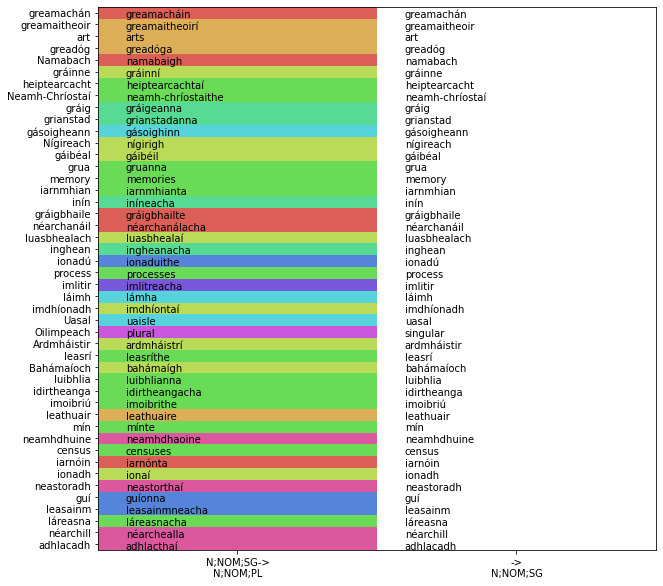

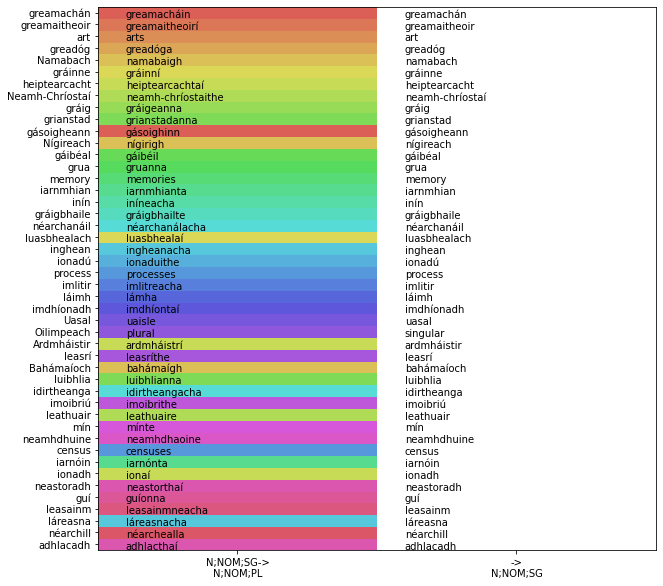

In [92]:
data.report(inflect)
colorByPolicy(data, inflect)
colorByPolicy(data, inflect, group="reference")

In [41]:
data.generateTrainingData()
#tsnePlot(data)
#inflect.fit(data, epochs=1, steps_per_epoch=10)
consolidate(data, inflect)

getting batch indices for policy 0 4 users 1000 instances
getting batch indices for policy 11 13 users 50 instances
getting batch indices for policy 3 1 users 50 instances
getting batch indices for policy 5 2 users 50 instances
getting batch indices for policy 6 3 users 50 instances
getting batch indices for policy 8 2 users 50 instances
getting batch indices for policy 9 1 users 50 instances
getting batch indices for policy 10 6 users 50 instances
getting batch indices for policy 12 3 users 50 instances
getting batch indices for policy 35 3 users 50 instances
getting batch indices for policy 23 2 users 50 instances
getting batch indices for policy 16 1 users 50 instances
getting batch indices for policy 29 1 users 50 instances
getting batch indices for policy 40 4 users 50 instances
Generated 1650 items over 14 policies
current assignment ('s', '') N;NOM;PL 0
size of that cluster 4
testing 10 with size 6
Generated 0 items over 14 policies
getting batch indices for policy 0 4 users 200

KeyboardInterrupt: ignored

In [ ]:
for kk, vv in data.policies.items():
  print(kk, vv)

print("-------")

for kk, vv in data.policyMembers().items():
  print(kk, vv)

print(outputSize, "ops")

#for (lemma, word, feats) in nom + englishWords:
#  assert(len(word) < 26), "Bad %s" % word

accTab = accuracyTable(data, inflect, group="policy")
prohibit = { kk : (vv < .9) for kk, vv in accTab.items() }
merges(inflect, data, group="policy", prohibit=prohibit)
accTab = accuracyTable(data, inflect, group="reference")
prohibit = { kk : (vv < .9) for kk, vv in accTab.items() }
merges(inflect, data, group="reference", prohibit=prohibit)
accTab = accuracyTable(data, inflect, group="policy")
colorByPolicy(data, inflect, accuracies=accTab)
accTab = accuracyTable(data, inflect, group="reference")
colorByPolicy(data, inflect, group="reference", accuracies=accTab)

In [ ]:
data.report(inflect)
colorByPolicy(data, inflect)
colorByPolicy(data, inflect, group="reference")

Starting eng-x-ir at 8
==================== ITERATION 8 ===================
==================== ITERATION 8 ===================


getting batch indices for policy 0 4 users 1000 instances
getting batch indices for policy 11 13 users 50 instances
getting batch indices for policy 3 5 users 50 instances
getting batch indices for policy 5 4 users 50 instances
getting batch indices for policy 10 6 users 50 instances
getting batch indices for policy 12 3 users 50 instances
getting batch indices for policy 29 4 users 50 instances
getting batch indices for policy 23 2 users 50 instances
getting batch indices for policy 16 1 users 50 instances
getting batch indices for policy 40 4 users 50 instances
Generated 1450 items over 10 policies
1000/1000 - 16s - loss: 2.6241 - categorical_accuracy: 1.0000 - zero_one_accuracy_2: 1.0000
Epoch 1/10
1000/1000 - 103s - loss: 2.6292 - categorical_accuracy: 0.9910 - zero_one_accuracy_2: 0.8110
Epoch 2/10
1000/1000 - 102s - loss: 2.6312 - categorical_accuracy

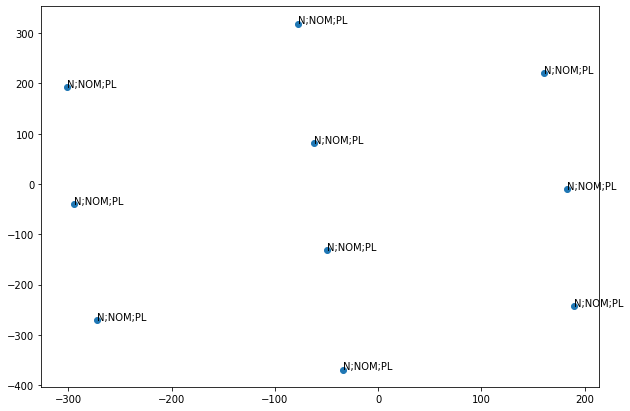

getting batch indices for policy 0 4 users 100 instances
Generated 100 items over 10 policies
getting batch indices for policy 11 13 users 100 instances
Generated 100 items over 10 policies
getting batch indices for policy 3 5 users 100 instances
Generated 100 items over 10 policies
getting batch indices for policy 5 4 users 100 instances
Generated 100 items over 10 policies
getting batch indices for policy 10 7 users 100 instances
Generated 100 items over 10 policies
getting batch indices for policy 12 3 users 100 instances
Generated 100 items over 10 policies
getting batch indices for policy 29 3 users 100 instances
Generated 100 items over 10 policies
getting batch indices for policy 23 2 users 100 instances
Generated 100 items over 10 policies
getting batch indices for policy 16 1 users 100 instances
Generated 100 items over 10 policies
getting batch indices for policy 40 4 users 100 instances
Generated 100 items over 10 policies
getting batch indices for policy 0 4 users 100 insta

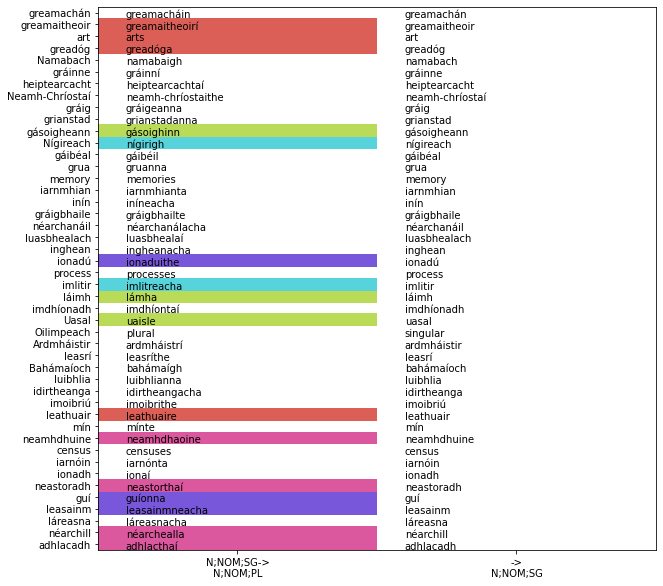

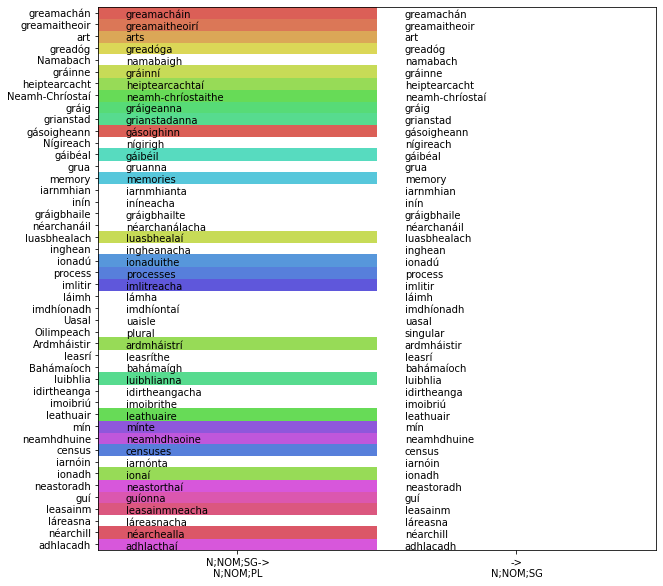

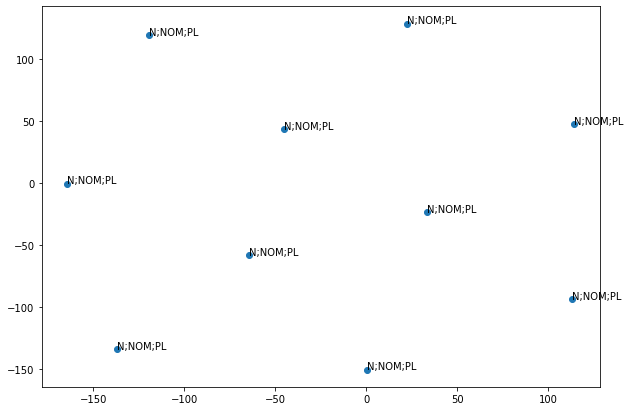

getting batch indices for policy 0 4 users 100 instances
Generated 100 items over 10 policies
getting batch indices for policy 11 13 users 100 instances
Generated 100 items over 10 policies
getting batch indices for policy 3 5 users 100 instances
Generated 100 items over 10 policies
getting batch indices for policy 5 4 users 100 instances
Generated 100 items over 10 policies
getting batch indices for policy 10 8 users 100 instances
Generated 100 items over 10 policies
getting batch indices for policy 12 3 users 100 instances
Generated 100 items over 10 policies
getting batch indices for policy 29 3 users 100 instances
Generated 100 items over 10 policies
getting batch indices for policy 16 1 users 100 instances
Generated 100 items over 10 policies
getting batch indices for policy 23 1 users 100 instances
Generated 100 items over 10 policies
getting batch indices for policy 40 4 users 100 instances
Generated 100 items over 10 policies
getting batch indices for policy 0 4 users 100 insta

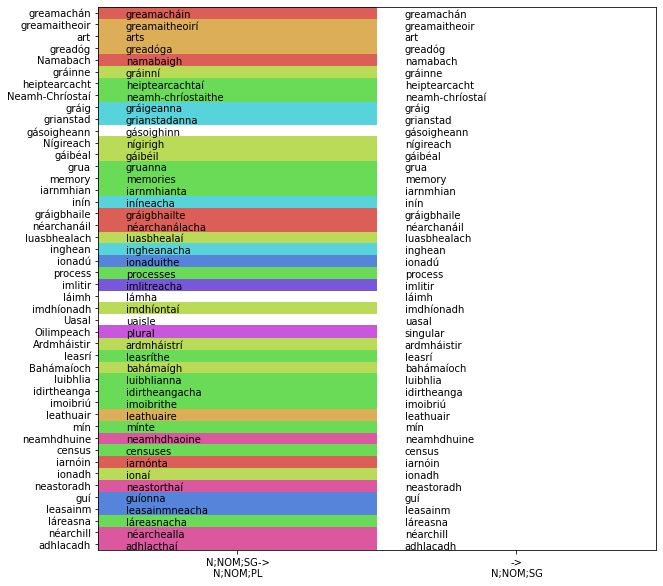

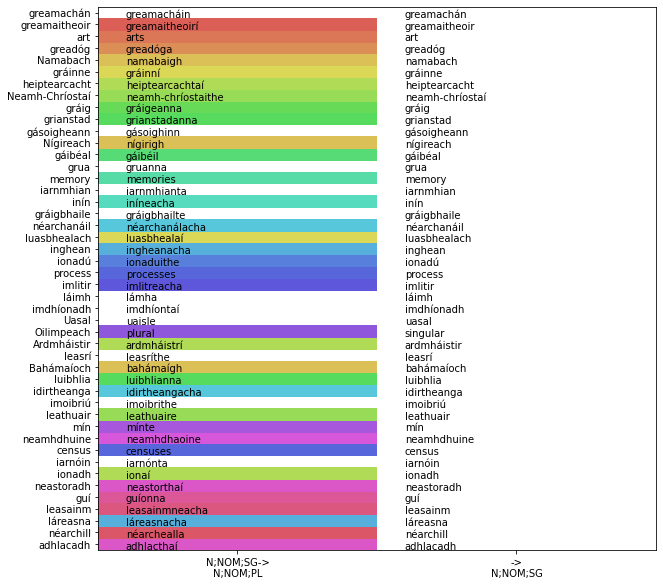

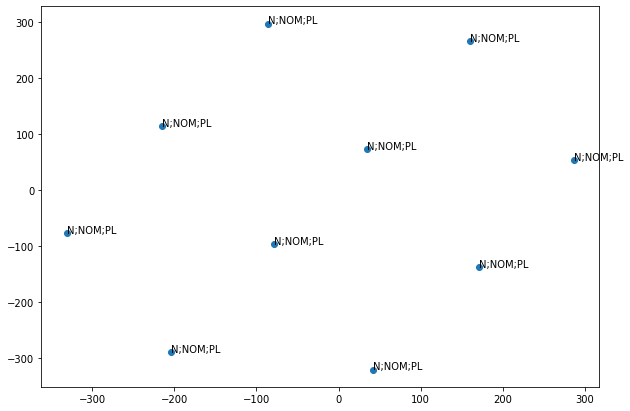

getting batch indices for policy 0 4 users 100 instances
Generated 100 items over 10 policies
getting batch indices for policy 11 13 users 100 instances
Generated 100 items over 10 policies
getting batch indices for policy 3 5 users 100 instances
Generated 100 items over 10 policies
getting batch indices for policy 5 4 users 100 instances
Generated 100 items over 10 policies
getting batch indices for policy 10 8 users 100 instances
Generated 100 items over 10 policies
getting batch indices for policy 12 3 users 100 instances
Generated 100 items over 10 policies
getting batch indices for policy 29 3 users 100 instances
Generated 100 items over 10 policies
getting batch indices for policy 16 1 users 100 instances
Generated 100 items over 10 policies
getting batch indices for policy 23 1 users 100 instances
Generated 100 items over 10 policies
getting batch indices for policy 40 4 users 100 instances
Generated 100 items over 10 policies
getting batch indices for policy 0 4 users 100 insta

In [ ]:
train("eng-x-ir", data, inflect, trainSteps=3, iters=10, resume=(8, 8))

In [73]:
irStats = pickle.load(open("drive/My Drive/model/irish-x-complexity-stats.dump", 'rb'))
stats = pickle.load(open("drive/My Drive/model/eng-x-ir-complexity-stats.dump", 'rb'))

In [86]:
def comparisonPlot(monoStats, biStats, dimensions):
  comparison = {}

  for mc, sub in monoStats.items():
    for cell, stt in sub.items():
      #print(stt)
      prPol, prRef, prExe, prInfl, nItems = stt
      values = {"policy" : prPol, "reference" : prRef, "exemplar": prExe, "inflection" : prInfl}
      total = 0
      for di in dimensions:
        total += np.abs(values[di])
      total /= nItems

    if mc in stats:
      prPol, prRef, prExe, prInfl, nItems = biStats[mc][cell]
      values = {"policy" : prPol, "reference" : prRef, "exemplar": prExe, "inflection" : prInfl}
      totalX = 0
      for di in dimensions:
        totalX += np.abs(values[di])
      totalX /= nItems
    
      comparison[mc, cell] = (total, totalX)
    else:
      print("nd code for", mc)

  fig, ax = plt.subplots()
  its = list(comparison.items())
  v1s = [xx[1][0] for xx in its]
  v2s = [xx[1][1] for xx in its]
  labels = [xx[0] for xx in its]
  colors = []
  nLabels = []
  for mc, cell in labels:
    ex = data.microclasses[mc][0]
    nLabels.append(ex)
    sharedPolicy = False
    policy = data.policies[mc, cell]
    members = data.policyMembers()[policy]
    for mem, xx in members:
      lems = data.microclasses[mem]
      if set(lems).intersection(data.langLemmas["src"]):
        sharedPolicy = True
        break
    
    if sharedPolicy:
      colors.append("r")
    else:
      colors.append("b")
    
  plt.scatter(v1s, v2s, c=colors)
  for ii in range(len(labels)):
    plt.text(v1s[ii], v2s[ii], nLabels[ii])
  lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
  ]
  plt.plot([lims[0], lims[1]], [lims[0], lims[1]])
  plt.show()

nd code for ('pual', 'singua')
nd code for ('acha', 'ai')


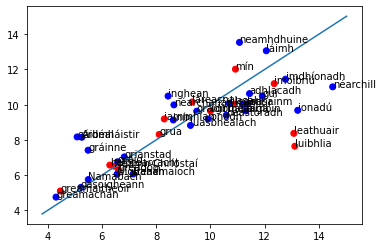

In [87]:
comparisonPlot(irStats, stats, ["policy", "reference", "exemplar", "inflection"])

nd code for ('pual', 'singua')
nd code for ('acha', 'ai')


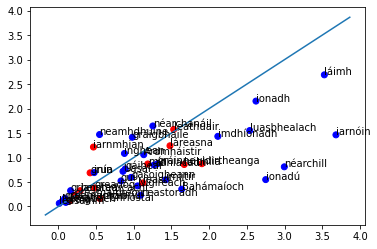

In [88]:
comparisonPlot(irStats, stats, ["policy"])

nd code for ('pual', 'singua')
nd code for ('acha', 'ai')


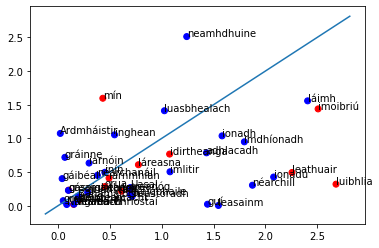

In [89]:
comparisonPlot(irStats, stats, ["reference"])

nd code for ('pual', 'singua')
nd code for ('acha', 'ai')


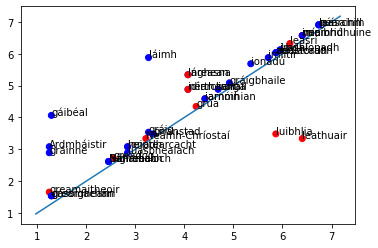

In [90]:
comparisonPlot(irStats, stats, ["exemplar"])

nd code for ('pual', 'singua')
nd code for ('acha', 'ai')


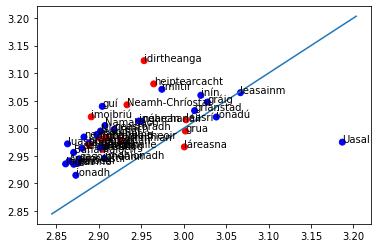

In [91]:
comparisonPlot(irStats, stats, ["inflection"])

In [103]:
def totalComplexity(stats, dimensions):
  res = 0
  nWords = 0
  for mc, sub in stats.items():
    for cell, stt in sub.items():
      #print(stt)
      prPol, prRef, prExe, prInfl, nItems = stt
      values = {"policy" : prPol, "reference" : prRef, "exemplar": prExe, "inflection" : prInfl}
      if any([np.isinf(xx) for xx in values.values()]):
        continue

      nWords += nItems
      total = 0
      for di in dimensions:
        total += np.abs(values[di])
      res += total
  
  return res / nWords

def srcMicroclass(mc, data):
  lems = data.microclasses[mc]
  return set(lems).intersection(data.langLemmas["src"])

irSubset = { xx : yy for xx, yy in stats.items() if not srcMicroclass(xx, data) }

print("Total complexity of Irish", totalComplexity(irStats, ["policy", "reference", "exemplar", "inflection"]))
print("Total complexity of xIrish", totalComplexity(irSubset, ["policy", "reference", "exemplar", "inflection"]))

for dim in ["policy", "reference", "exemplar", "inflection"]:
  print("%s complexity of Irish" % dim, totalComplexity(irStats, [dim]))
  print("%s complexity of xIrish" % dim, totalComplexity(irSubset, [dim]))

Total complexity of Irish 5.7222791708780765
Total complexity of xIrish 6.131973452028291
policy complexity of Irish 0.4188098513503894
policy complexity of xIrish 0.36989509925937214
reference complexity of Irish 0.24096909409209274
reference complexity of xIrish 0.2312346371550427
exemplar complexity of Irish 2.1465469244203774
exemplar complexity of xIrish 2.542301380913268
inflection complexity of Irish 2.915953301015216
inflection complexity of xIrish 2.9885423347006075


In [111]:
def classComp(stats, dimensions):
  comps = {}
  for mc, sub in stats.items():
    for cell, stt in sub.items():
      total = 0
      #print(stt)
      prPol, prRef, prExe, prInfl, nItems = stt
      values = {"policy" : prPol, "reference" : prRef, "exemplar": prExe, "inflection" : prInfl}
      if any([np.isinf(xx) for xx in values.values()]):
        continue
      
      try:
        if srcMicroclass(mc, data):
          continue
      except:
        continue

      for dim in dimensions:
        total += np.abs(values[dim])
      
      comps[mc] = total / nItems
  
  return comps

irComp = classComp(irStats, ["policy", "reference", "exemplar", "inflection"])
for xx in sorted(irComp.items(), key=lambda xx: xx[1], reverse=True)[:10]:
  lems = data.microclasses[xx[0]]
  rep = lems[0]
  print(rep, xx[1])

print()

xComp = classComp(stats, ["policy", "reference", "exemplar", "inflection"])
for xx in sorted(xComp.items(), key=lambda xx: xx[1], reverse=True)[:10]:
  lems = data.microclasses[xx[0]]
  rep = lems[0]
  print(rep, xx[1])

néarchill 14.50887581471067
ionadú 13.220873272039452
luibhlia 13.113666887266804
leathuair 13.077280520169147
imdhíonadh 12.769637404770341
imoibriú 12.353420498707447
láimh 12.062737311744858
guí 11.91562527851643
adhlacadh 11.44378316485602
leasainm 11.36466906009707

neamhdhuine 13.535967209404115
láimh 13.059749417166321
mín 12.01640693701533
imdhíonadh 11.44677675727325
imoibriú 11.193401454067109
néarchill 11.01246068787543
adhlacadh 10.62826635605363
guí 10.493366064947521
inghean 10.488732553981526
láreasna 10.154931669578863


What to do:

* CELEX nouns
* Retry some algorithmic tweaks (non-identity char proj., 2-layer encoder)
* Find somewhere else to run this!